In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import torchvision.transforms as transforms

from torch.autograd import Variable

import os
import time

from PIL.Image import BICUBIC
from torchvision.datasets import MNIST
from ram import RecurrentAttentionModel
from trainer import *

### MNIST dataset
Testing out this model and training algorithm implementation on the basic MNIST dataset, which is pretty simple so hopefully everything goes well.

In [2]:
num_train_data_copies = 1  # Number of times to load the training dataset (with augmentation)
num_eval_data_copies = 1   # Number of times to load the evaluation dataset (with augmentation)
test_val_split = 0.5       # Percentage of the test set to use as validation data
batch_size = 1             # Batch size for training
eval_batch_size = 1        # Batch size for validation and testing

# Image parameters
num_classes = 10       # Digits 0-9
image_size = 28        # MNIST images are 28x28 b/w images
in_channels = 1        # Number of color channels in the inputs (MNIST dataset is grayscale)

glimpse_sizes = [8]  #[5, 10, 18]
padding = int(np.ceil(glimpse_sizes[-1] / 2))
padded_img_size = image_size + 2*padding

In [3]:
# Down/load MNIST data
mnist_data_loc = os.path.join('data', 'mnist')
data_transforms = transforms.Compose([ # Keep things pretty basic for now
    # Pad images with 0s so the GlimpseSensor won't have to
    transforms.Pad(padding = padding),
    # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255]
    # to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    transforms.ToTensor(),
])

'''
Can increase the number of images in each dataset by loading up the data again,
applying the (random) transformations, then concatenating it all together
'''
### Training Dataset and DataLoader
all_train_datasets = [
    MNIST(
        root = mnist_data_loc, train = True,
        download = True, transform = data_transforms
    ) for _ in range(num_train_data_copies)
]
train_datasets = utils.data.ConcatDataset(all_train_datasets)
train_data = utils.data.DataLoader(train_datasets, batch_size = batch_size, shuffle = True)
num_train_data = len(train_datasets)
num_train_batches = len(train_data)

### Validation and Test Dataset and DataLoader
all_eval_datasets = [
    MNIST(
        root = mnist_data_loc, train = False,
        download = True, transform = data_transforms
    ) for _ in range(num_eval_data_copies)
]
eval_datasets = utils.data.ConcatDataset(all_eval_datasets)
num_eval_data = len(eval_datasets)

eval_split_pt = int(test_val_split * num_eval_data)
eval_idx = list(range(num_eval_data))
np.random.shuffle(eval_idx)

val_idx, test_idx = eval_idx[:eval_split_pt], eval_idx[eval_split_pt:]

val_sampler = utils.data.sampler.SubsetRandomSampler(val_idx)
val_data = utils.data.DataLoader(
    eval_datasets, batch_size = eval_batch_size, sampler = val_sampler
)
num_val_data = len(val_sampler)
num_val_batches = len(val_data)

test_sampler = utils.data.sampler.SubsetRandomSampler(test_idx)
test_data = utils.data.DataLoader(
    eval_datasets, batch_size = eval_batch_size, sampler = test_sampler
)
num_test_data = len(test_sampler)
num_test_batches = len(test_data)

print('Num:\n- train data: %d (%d batches)\n- val data: %d (%d batches)\n- test data: %d (%d batches)' % (
    num_train_data, num_train_batches, num_val_data, num_val_batches, num_test_data, num_test_batches
))

Num:
- train data: 60000 (60000 batches)
- val data: 5000 (5000 batches)
- test data: 5000 (5000 batches)


In [4]:
# Basic training hyperparameters
lr = 1e-3
grad_clip = 2
lr_step_size = 1
steps_per_epoch = int(num_train_data_copies * 15)  # Number of times to step the lr scheduler in an epoch
decay_rate = 0.995

# RL training hyperparameters
end_train_ep_early = False     # End each training episode early after a correct classification
assert (end_train_ep_early and batch_size == 1) or not end_train_ep_early
max_ep_len = 6                 # Maximum number of glimpses per episode
num_epochs = 400               # Number of times to go through all of the training examples
early_stopping = int(num_epochs * 0.02)

random_start_loc = True
error_penalty = 0.  # Amount of penalty to apply each time the agent makes an incorrect classification (<= 0.)
gamma = 1.0         # Reward discount factor

# Etc
log_freq = num_train_batches // 4    # How often to print a training log in an epoch
viz_freq = num_train_batches // 2     # How often to visualize the glimpses in an epoch
eval_viz_freq = num_val_batches // 2  # How often to visualize the glimpses in an epoch

### Model
Need to modify class implementation so that any recurrent `nn.Module` instance can be passed in when initializing a new `RecurrentAttentionModel` to make it easier to try this visual attention mechanism out with different core recurrent networks.

In [5]:
# Model hyperparameters
glimpse_g_size = 128    # Size of the transformed Glimpse representation in the GlimpseNetwork
loc_g_size = 128        # Size of the transformed location representation in the GlimpseNetwork
glimpse_net_size = 256  # Size of the GlimpseNetwork output
rnn_state_size = 256
sensor_size = 8         # Size of the glimpses after resizing
g_rep_op = 'mul'

dropout = 0.0
# Standard deviation to use when sampling the glimpse location coordinates from a normal distribution
loc_std = 0.22

In [ ]:
# Initialize the network
model = RecurrentAttentionModel(
    image_size = image_size, in_channels = in_channels,
    glimpse_g_size = glimpse_g_size, loc_g_size = loc_g_size,
    glimpse_net_size = glimpse_net_size, g_rep_op = g_rep_op,
    rnn_state_size = rnn_state_size, num_actions = num_classes,
    sensor_size = sensor_size, glimpse_sizes = glimpse_sizes,
    pad_imgs = False, padding = padding, dropout = dropout
)
num_parameters = sum([p.numel() for p in model.parameters()])
print('Model has %d parameters' % num_parameters)

# Criterion, optimizer, learning rate scheduler
class_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = decay_rate)

Model has 547085 parameters


Epoch   1/400) lr = 0.001
 b  15000/ 60000 >> 105.3 ms/b | lr: 9.85e-04 | grad 2norm: 32.48 | grad inf norm:  8.185
         Weights || abs max:  0.809 (16943.221) | mean:  1.526e-04 ( 0.035) | var: 8.453e-03 (5087855.000)
          Biases || abs max:  0.588 (  355.550) | mean:  2.044e-02 ( 0.372) | var: 1.183e-02 (55844.031)
                    class loss: 1.020 | steps: 4.486 | reward:  0.605 | acc.: 60.53%
                 --------------------------------------------------------------------------------
 b  30000/ 60000 >> 103.8 ms/b | lr: 9.66e-04 | grad 2norm: 33.81 | grad inf norm:  8.373
         Weights || abs max:  2.397 ( 3782.815) | mean:  6.851e-04 ( 0.010) | var: 1.841e-02 (31105.865)
          Biases || abs max:  0.604 (   13.065) | mean:  2.432e-02 ( 0.008) | var: 2.470e-02 (   25.660)
                    class loss: 0.899 | steps: 4.460 | reward:  0.628 | acc.: 62.84%

	Target class: 5 | Discounted rewards: [0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
	                | Ba

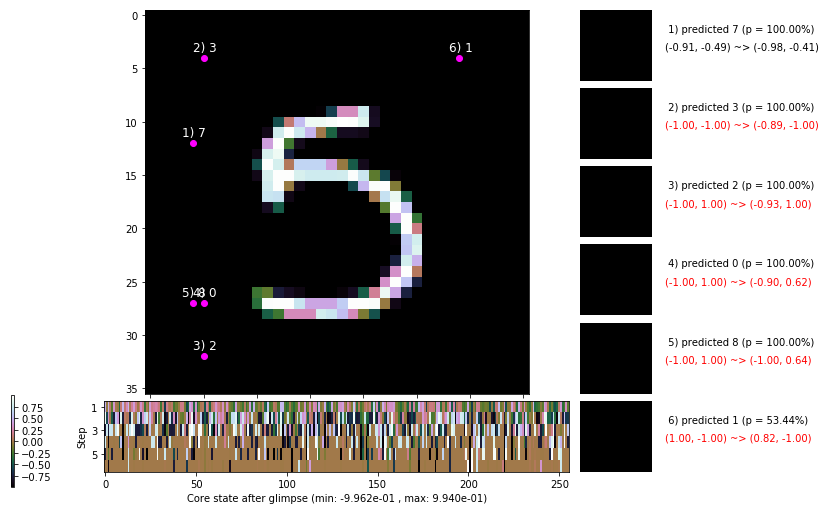

                 --------------------------------------------------------------------------------
 b  45000/ 60000 >> 103.7 ms/b | lr: 9.46e-04 | grad 2norm: 34.43 | grad inf norm:  8.407
         Weights || abs max:  3.258 ( 4528.679) | mean:  1.492e-03 ( 0.013) | var: 2.772e-02 ( 5074.345)
          Biases || abs max:  0.693 (    8.025) | mean:  2.463e-02 ( 0.005) | var: 3.822e-02 (    4.761)
                    class loss: 0.893 | steps: 4.458 | reward:  0.622 | acc.: 62.23%
                 --------------------------------------------------------------------------------
 b  60000/ 60000 >> 103.5 ms/b | lr: 9.32e-04 | grad 2norm: 32.99 | grad inf norm:  8.529
         Weights || abs max:  3.759 ( 6458.023) | mean:  1.355e-03 ( 0.018) | var: 3.632e-02 (39154.547)
          Biases || abs max:  0.940 (    6.343) | mean:  2.390e-02 ( 0.005) | var: 4.938e-02 (   29.732)
                    class loss: 0.935 | steps: 4.485 | reward:  0.626 | acc.: 62.63%

	Target class: 1 | Discounted rew

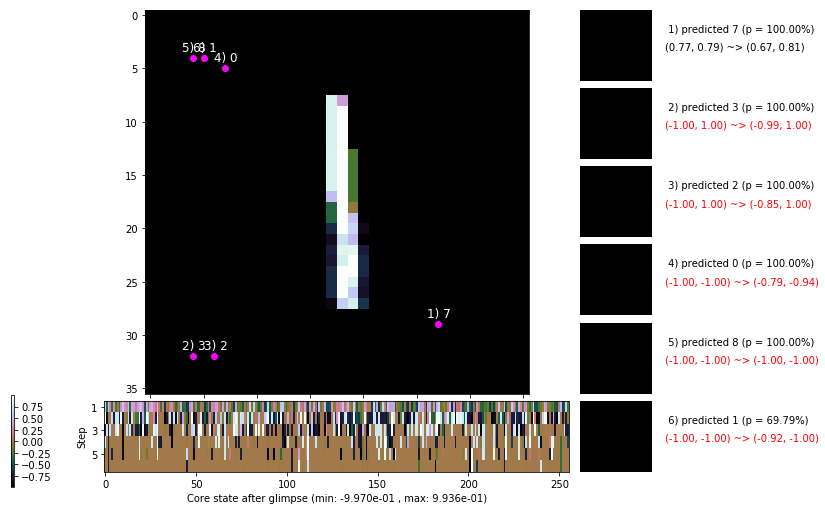

                 --------------------------------------------------------------------------------
                                             ---===  VALIDATION  ===---

	Target class: 1 | Discounted rewards: [1.000, 1.000, 1.000, 1.000, 1.000, 1.000]


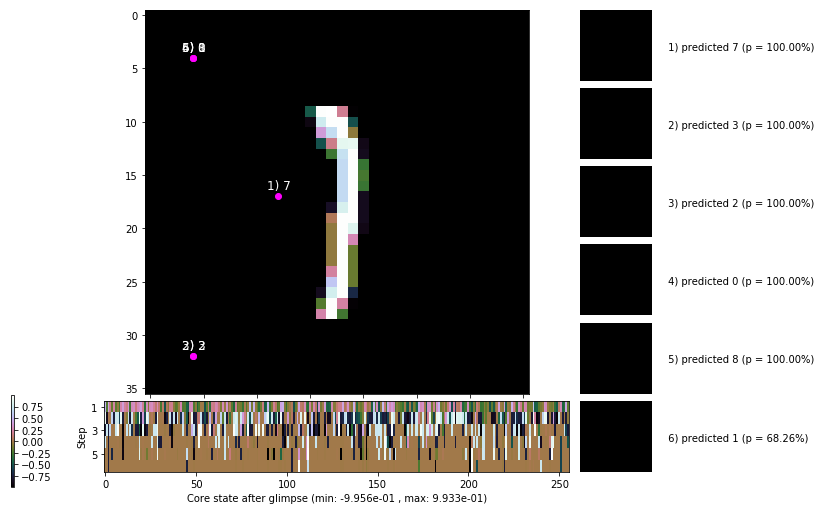


	Target class: 6 | Discounted rewards: [0.000, 0.000, 0.000, 0.000, 0.000, 0.000]


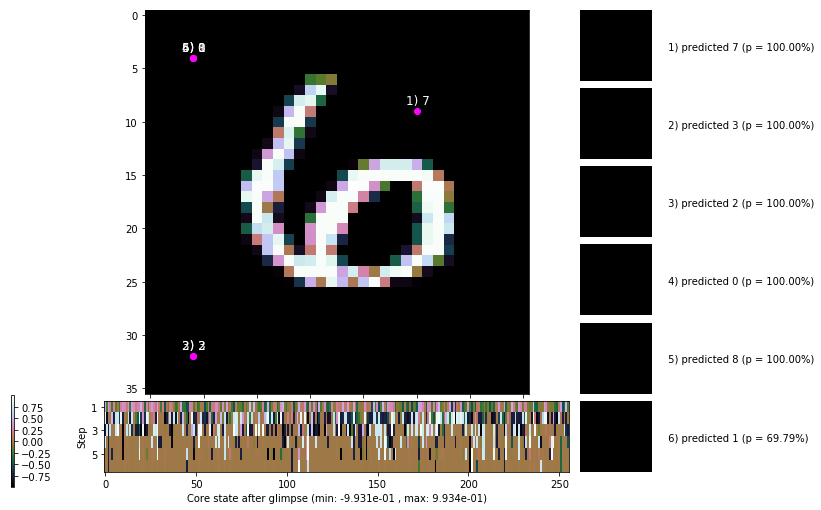

                                       ---===  MODEL PARAM DIAGNOSTICS  ===---


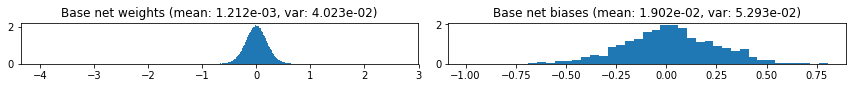

                                         Location network weights and biases


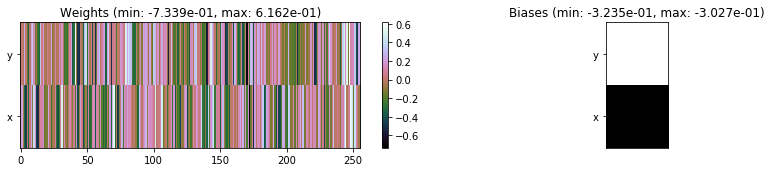

---------------------------------------------------------------------------------------------------------------------
Elapsed time: 6244.93 sec | TRAIN >> class loss: 0.9370 | steps:  4.472    | reward:  0.6206    | acc.: 62.057% 
                          | VAL   >> class loss: 0.9990 | steps:  4.483    | reward:  0.6346    | acc.: 63.460% 


Epoch   2/400) lr = 0.0009276


H:\Users\Andrew\Anaconda3\envs\conda_jupyter\lib\site-packages\numpy\lib\nanfunctions.py:1315: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


 b  15000/ 60000 >> 103.5 ms/b | lr: 9.14e-04 | grad 2norm: 33.83 | grad inf norm:  8.518
         Weights || abs max:  4.125 (      inf) | mean:  1.177e-03 (   inf) | var: 4.384e-02 (      nan)
          Biases || abs max:  1.186 (    3.987) | mean:  2.542e-02 ( 0.003) | var: 6.394e-02 (    2.229)
                    class loss: 0.960 | steps: 4.474 | reward:  0.628 | acc.: 62.82%
                 --------------------------------------------------------------------------------
 b  30000/ 60000 >> 104.0 ms/b | lr: 8.96e-04 | grad 2norm: 34.11 | grad inf norm:  8.621
         Weights || abs max:  4.262 (11196.075) | mean:  6.666e-04 ( 0.030) | var: 5.265e-02 (248114.312)
          Biases || abs max:  1.513 (    7.104) | mean:  2.201e-02 ( 0.005) | var: 7.498e-02 (    2.861)
                    class loss: 1.003 | steps: 4.472 | reward:  0.631 | acc.: 63.06%

	Target class: 3 | Discounted rewards: [1.000, 1.000]
	                | Baseline rewards:   [0.957, 0.935]


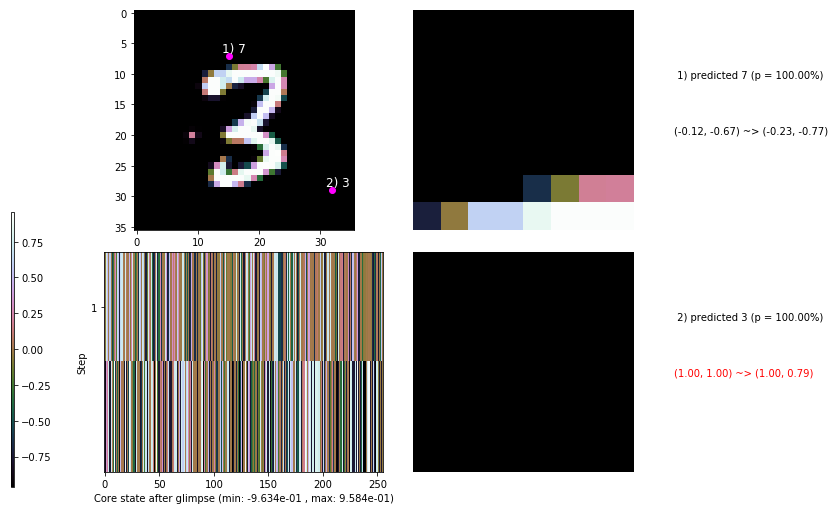

                 --------------------------------------------------------------------------------
 b  45000/ 60000 >> 104.6 ms/b | lr: 8.78e-04 | grad 2norm: 34.70 | grad inf norm:  8.650
         Weights || abs max:  4.321 (11377.776) | mean:  2.703e-04 ( 0.032) | var: 6.105e-02 (66632.062)
          Biases || abs max:  1.625 (   24.397) | mean:  2.021e-02 ( 0.015) | var: 8.575e-02 (  237.313)
                    class loss: 1.059 | steps: 4.485 | reward:  0.633 | acc.: 63.25%
                 --------------------------------------------------------------------------------
 b  60000/ 60000 >> 104.3 ms/b | lr: 8.65e-04 | grad 2norm: 33.57 | grad inf norm:  8.514
         Weights || abs max:  4.184 (28593.775) | mean:  2.781e-04 ( 0.064) | var: 6.957e-02 (6521020.000)
          Biases || abs max:  1.689 (   26.108) | mean:  1.504e-02 ( 0.019) | var: 9.494e-02 (   92.689)
                    class loss: 1.115 | steps: 4.469 | reward:  0.641 | acc.: 64.12%

	Target class: 8 | Discounted r

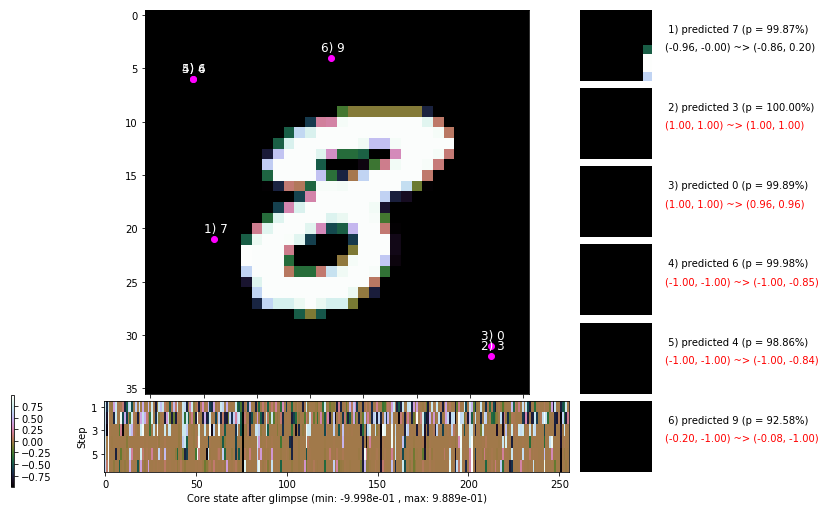

                 --------------------------------------------------------------------------------
                                             ---===  VALIDATION  ===---

	Target class: 5 | Discounted rewards: [0.000, 0.000, 0.000, 0.000, 0.000, 0.000]


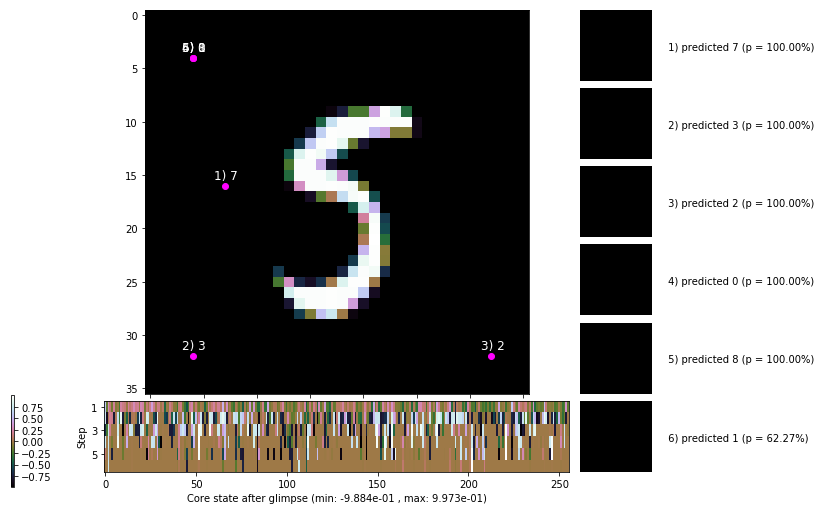


	Target class: 5 | Discounted rewards: [0.000, 0.000, 0.000, 0.000, 0.000, 0.000]


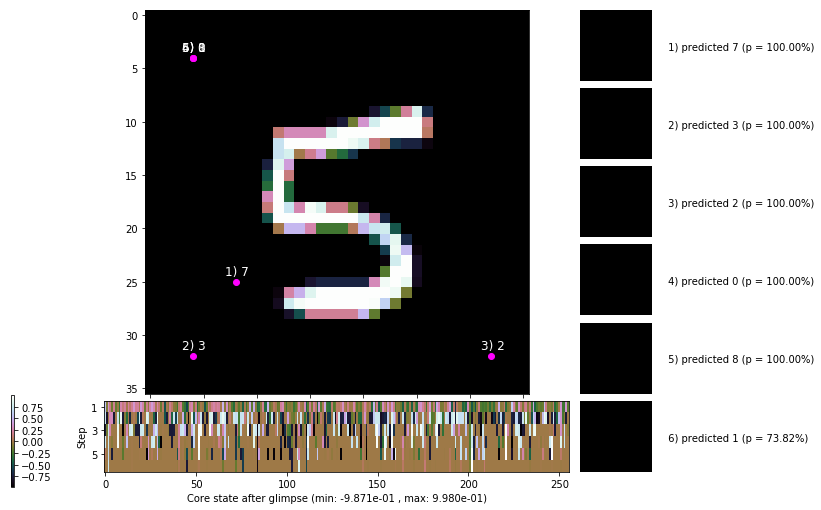

                                       ---===  MODEL PARAM DIAGNOSTICS  ===---


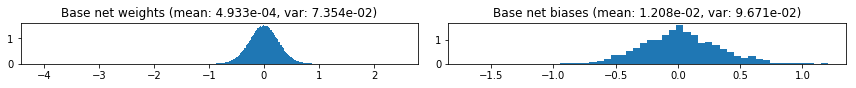

                                         Location network weights and biases


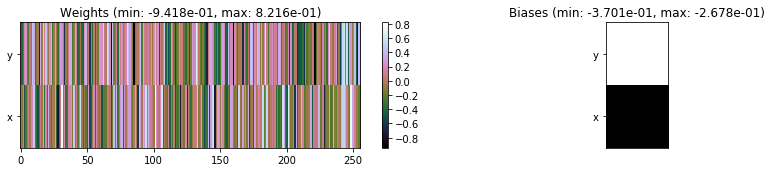

---------------------------------------------------------------------------------------------------------------------
Elapsed time: 6248.57 sec | TRAIN >> class loss: 1.0342 | steps:  4.475 :( | reward:  0.6331    | acc.: 63.313% 
                          | VAL   >> class loss: 1.1895 | steps:  4.468    | reward:  0.6348    | acc.: 63.480% 


Epoch   3/400) lr = 0.0008604
 b  15000/ 60000 >> 103.8 ms/b | lr: 8.48e-04 | grad 2norm: 30.79 | grad inf norm:  8.343
         Weights || abs max:  4.144 (      inf) | mean:  3.975e-04 (   inf) | var: 7.759e-02 (      nan)
          Biases || abs max:  1.615 (   49.256) | mean:  9.884e-03 ( 0.031) | var: 1.017e-01 ( 1110.804)
                    class loss: 1.091 | steps: 4.437 | reward:  0.650 | acc.: 64.99%
                 --------------------------------------------------------------------------------
 b  30000/ 60000 >> 103.9 ms/b | lr: 8.31e-04 | grad 2norm: 30.58 | grad inf norm:  8.116
         Weights || abs max:  4.126 (12596.206) | m

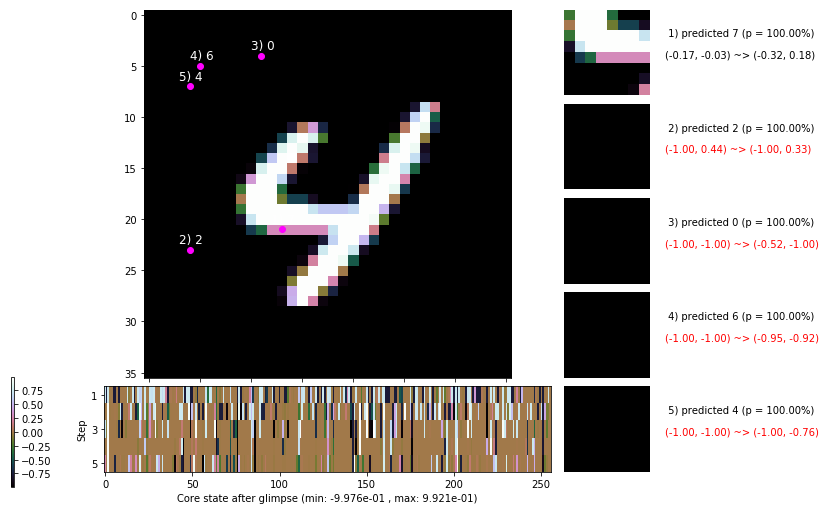

                 --------------------------------------------------------------------------------
 b  45000/ 60000 >> 103.4 ms/b | lr: 8.14e-04 | grad 2norm: 28.70 | grad inf norm:  7.890
         Weights || abs max:  3.866 (      inf) | mean:  6.003e-04 (   inf) | var: 9.210e-02 (      nan)
          Biases || abs max:  1.605 (   40.444) | mean:  1.763e-02 ( 0.027) | var: 1.205e-01 (  373.641)
                    class loss: 0.993 | steps: 4.357 | reward:  0.669 | acc.: 66.89%
                 --------------------------------------------------------------------------------
 b  60000/ 60000 >> 103.3 ms/b | lr: 8.02e-04 | grad 2norm: 28.96 | grad inf norm:  7.954
         Weights || abs max:  3.625 (13127.330) | mean:  6.404e-04 ( 0.037) | var: 9.908e-02 (200980.703)
          Biases || abs max:  1.591 (  488.949) | mean:  1.989e-02 ( 0.201) | var: 1.258e-01 (1194947.125)
                    class loss: 0.961 | steps: 4.333 | reward:  0.660 | acc.: 65.96%

	Target class: 8 | Discounted 

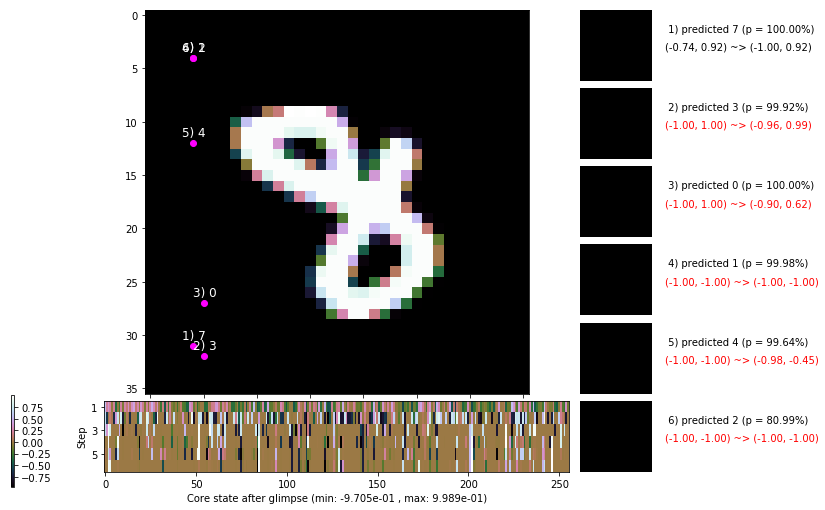

                 --------------------------------------------------------------------------------
                                             ---===  VALIDATION  ===---

	Target class: 1 | Discounted rewards: [0.000, 0.000, 0.000, 0.000, 0.000, 0.000]


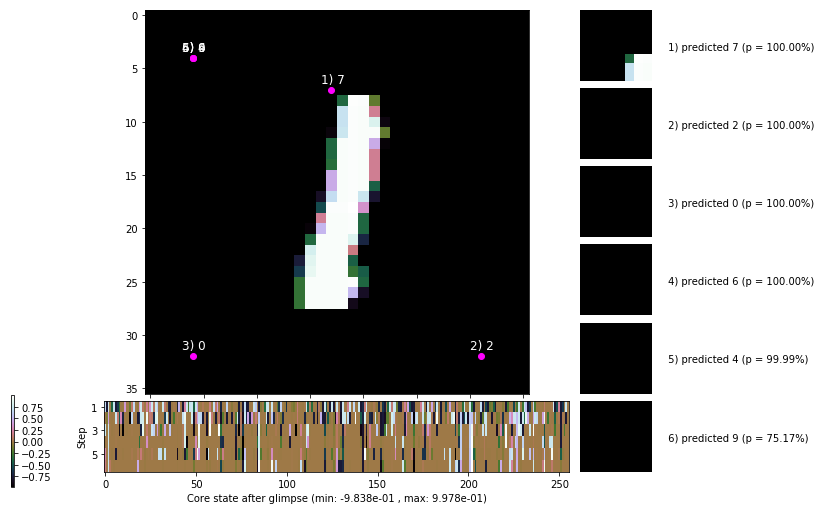


	Target class: 6 | Discounted rewards: [0.000, 0.000, 0.000, 0.000, 0.000, 0.000]


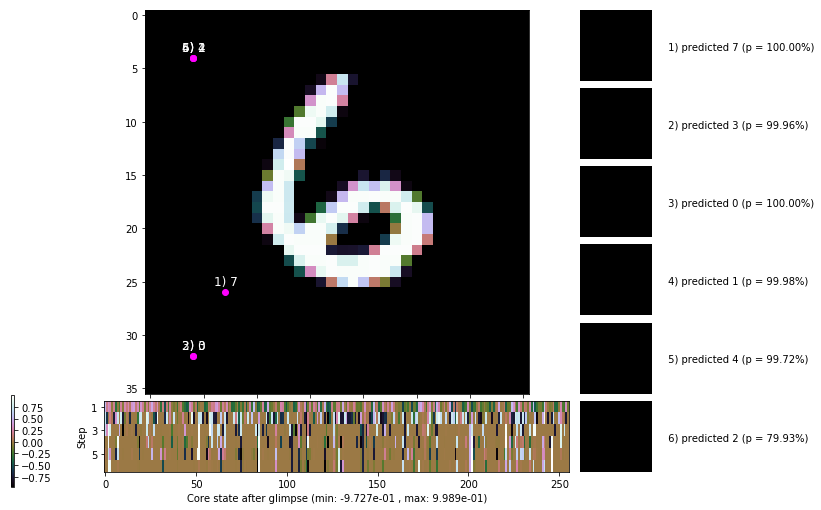

                                       ---===  MODEL PARAM DIAGNOSTICS  ===---


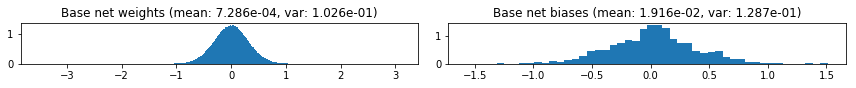

                                         Location network weights and biases


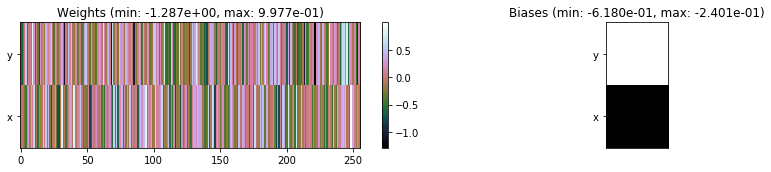

---------------------------------------------------------------------------------------------------------------------
Elapsed time: 6217.50 sec | TRAIN >> class loss: 1.0251 | steps:  4.383    | reward:  0.6596    | acc.: 65.957% 
                          | VAL   >> class loss: 1.0095 | steps:  4.334    | reward:  0.6578    | acc.: 65.780% 


Epoch   4/400) lr = 0.0007981
 b  15000/ 60000 >> 103.6 ms/b | lr: 7.86e-04 | grad 2norm: 29.41 | grad inf norm:  7.862
         Weights || abs max:  3.499 (12352.574) | mean:  6.522e-04 ( 0.036) | var: 1.057e-01 (49691.871)
          Biases || abs max:  1.595 (   88.746) | mean:  1.888e-02 ( 0.048) | var: 1.301e-01 ( 6655.433)
                    class loss: 0.984 | steps: 4.340 | reward:  0.667 | acc.: 66.67%
                 --------------------------------------------------------------------------------
 b  30000/ 60000 >> 103.3 ms/b | lr: 7.71e-04 | grad 2norm: 28.38 | grad inf norm:  7.659
         Weights || abs max:  3.951 (10320.509) | m

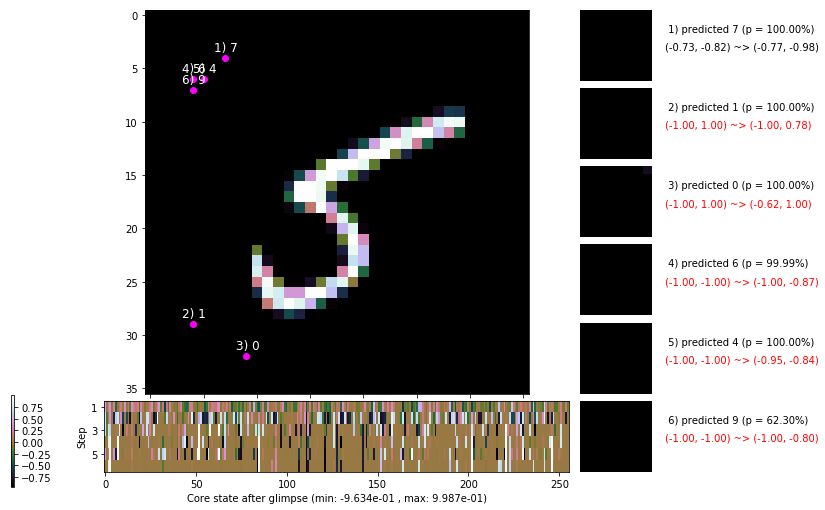

                 --------------------------------------------------------------------------------
 b  45000/ 60000 >> 103.2 ms/b | lr: 7.55e-04 | grad 2norm: 28.81 | grad inf norm:  7.699
         Weights || abs max:  4.031 (18541.482) | mean:  4.903e-04 ( 0.047) | var: 1.197e-01 (806875.188)
          Biases || abs max:  1.663 (   72.895) | mean:  1.500e-02 ( 0.050) | var: 1.401e-01 (  702.196)
                    class loss: 1.121 | steps: 4.220 | reward:  0.685 | acc.: 68.49%
                 --------------------------------------------------------------------------------
 b  60000/ 60000 >> 103.0 ms/b | lr: 7.44e-04 | grad 2norm: 28.06 | grad inf norm:  7.381
         Weights || abs max:  4.080 (14508.826) | mean:  2.858e-04 ( 0.040) | var: 1.262e-01 (247235.719)
          Biases || abs max:  1.794 (   74.659) | mean:  1.622e-02 ( 0.053) | var: 1.430e-01 ( 1525.639)
                    class loss: 1.057 | steps: 4.157 | reward:  0.699 | acc.: 69.93%

	Target class: 8 | Discounted r

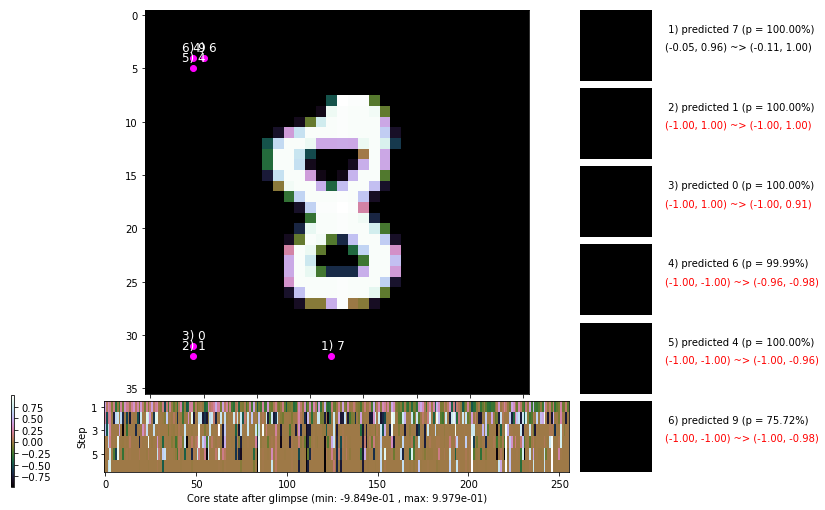

                 --------------------------------------------------------------------------------
                                             ---===  VALIDATION  ===---

	Target class: 7 | Discounted rewards: [0.000, 0.000, 0.000, 0.000, 0.000, 0.000]


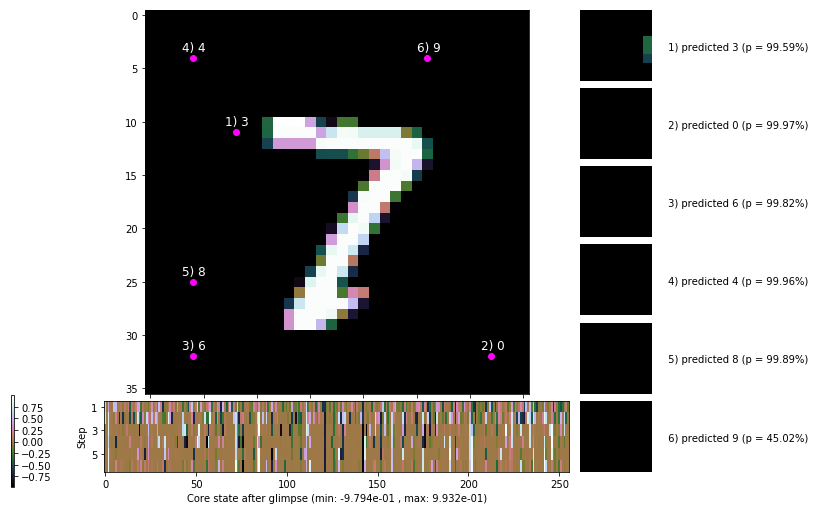


	Target class: 0 | Discounted rewards: [1.000, 1.000, 1.000]


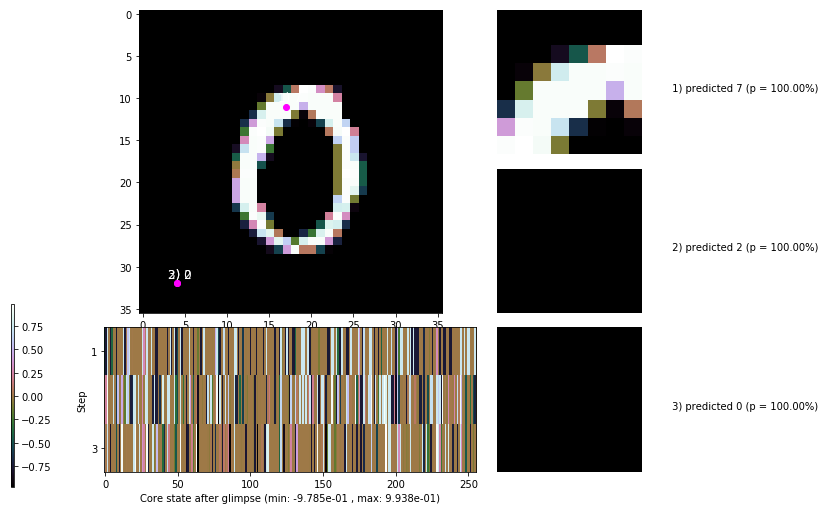

                                       ---===  MODEL PARAM DIAGNOSTICS  ===---


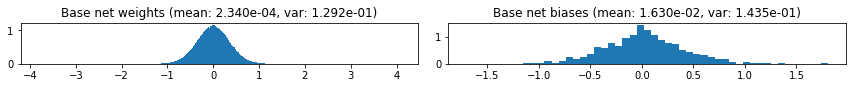

                                         Location network weights and biases


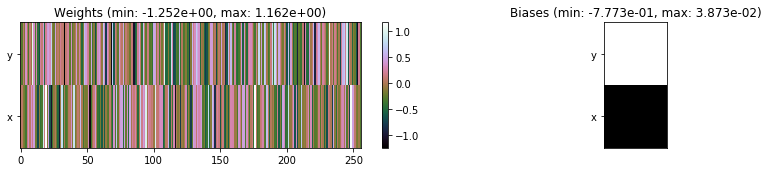

---------------------------------------------------------------------------------------------------------------------
Elapsed time: 6199.01 sec | TRAIN >> class loss: 1.0420 | steps:  4.248    | reward:  0.6826    | acc.: 68.263% 
                          | VAL   >> class loss: 0.9642 | steps:  4.204    | reward:  0.6910    | acc.: 69.100% 


Epoch   5/400) lr = 0.0007403
 b  15000/ 60000 >> 103.1 ms/b | lr: 7.29e-04 | grad 2norm: 28.09 | grad inf norm:  7.429
         Weights || abs max:  3.994 (28640.254) | mean:  2.150e-04 ( 0.066) | var: 1.321e-01 (3799587.250)
          Biases || abs max:  1.727 (  116.761) | mean:  1.585e-02 ( 0.070) | var: 1.453e-01 ( 4002.882)
                    class loss: 1.071 | steps: 4.153 | reward:  0.697 | acc.: 69.69%
                 --------------------------------------------------------------------------------
 b  30000/ 60000 >> 102.8 ms/b | lr: 7.15e-04 | grad 2norm: 25.97 | grad inf norm:  7.013
         Weights || abs max:  3.906 (16409.863) |

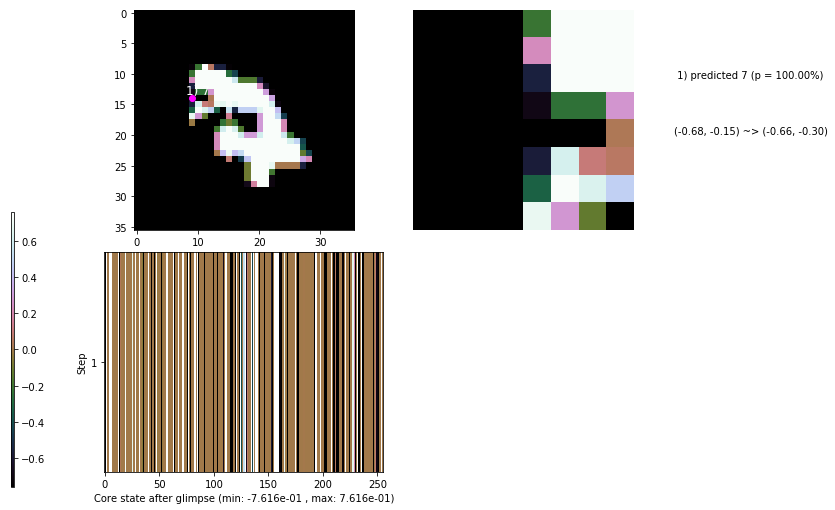

                 --------------------------------------------------------------------------------
 b  45000/ 60000 >> 102.4 ms/b | lr: 7.01e-04 | grad 2norm: 26.76 | grad inf norm:  7.194
         Weights || abs max:  4.008 (16417.396) | mean:  2.168e-04 ( 0.045) | var: 1.433e-01 (363604.344)
          Biases || abs max:  1.796 (   80.984) | mean:  1.303e-02 ( 0.055) | var: 1.543e-01 (  818.434)
                    class loss: 1.010 | steps: 4.130 | reward:  0.706 | acc.: 70.59%
                 --------------------------------------------------------------------------------
 b  60000/ 60000 >> 102.9 ms/b | lr: 6.90e-04 | grad 2norm: 25.70 | grad inf norm:  6.903
         Weights || abs max:  4.079 (14898.885) | mean:  2.096e-04 ( 0.044) | var: 1.487e-01 (165812.438)
          Biases || abs max:  1.798 (   99.114) | mean:  1.064e-02 ( 0.063) | var: 1.560e-01 ( 2852.216)
                    class loss: 0.979 | steps: 4.085 | reward:  0.720 | acc.: 71.97%

	Target class: 8 | Discounted r

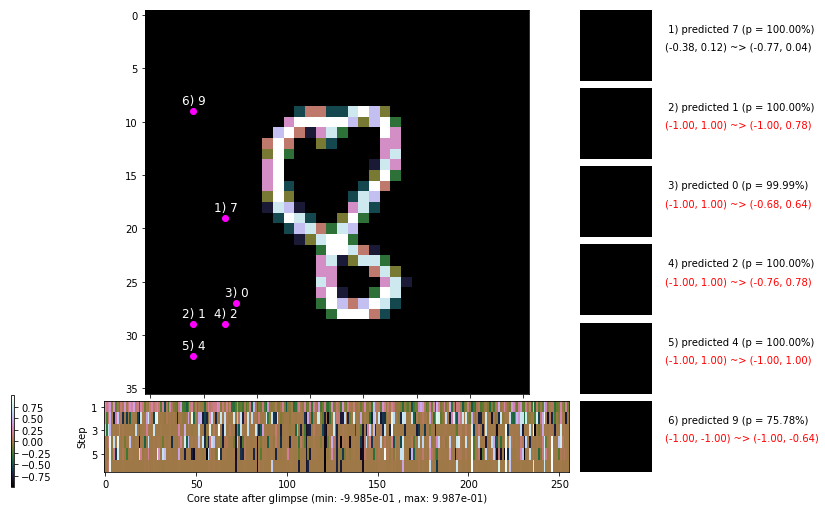

                 --------------------------------------------------------------------------------
                                             ---===  VALIDATION  ===---

	Target class: 0 | Discounted rewards: [1.000, 1.000, 1.000]


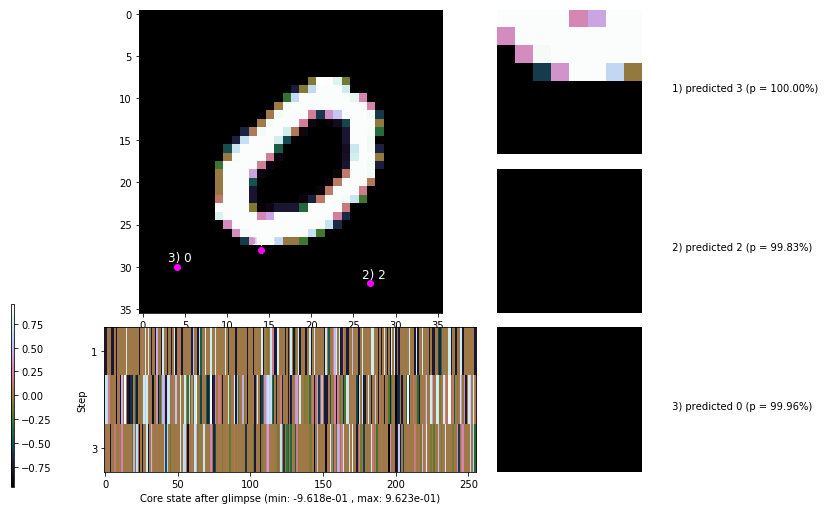


	Target class: 5 | Discounted rewards: [0.000, 0.000, 0.000, 0.000, 0.000, 0.000]


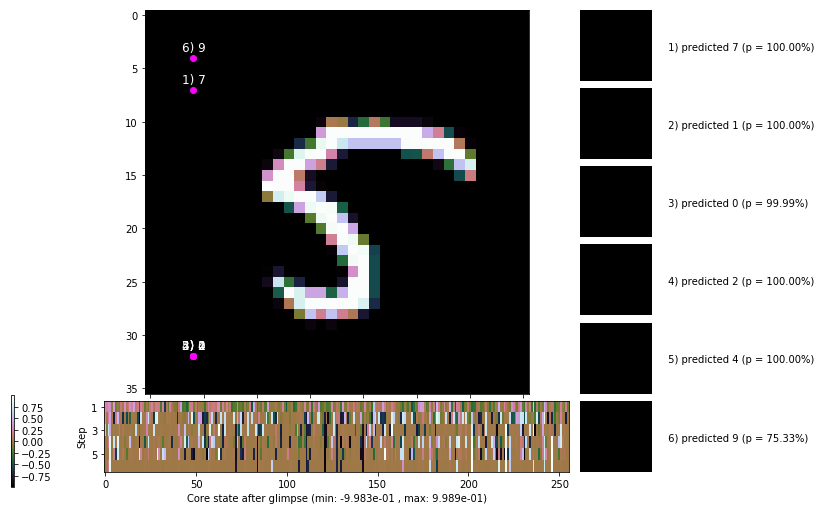

                                       ---===  MODEL PARAM DIAGNOSTICS  ===---


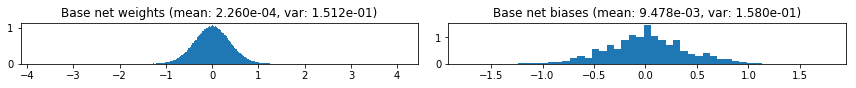

                                         Location network weights and biases


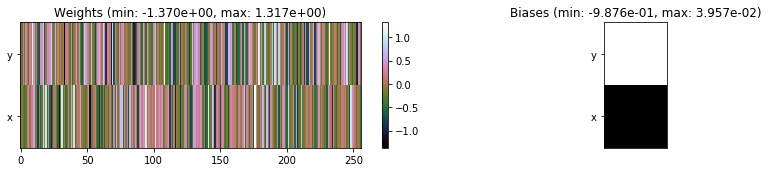

---------------------------------------------------------------------------------------------------------------------
Elapsed time: 6169.94 sec | TRAIN >> class loss: 1.0189 | steps:  4.121    | reward:  0.7092    | acc.: 70.920% 
                          | VAL   >> class loss: 0.8573 | steps:  4.047    | reward:  0.7344    | acc.: 73.440% 


Epoch   6/400) lr = 0.0006866
 b  15000/ 60000 >> 102.5 ms/b | lr: 6.76e-04 | grad 2norm: 25.76 | grad inf norm:  6.847
         Weights || abs max:  4.044 (27238.908) | mean:  1.729e-04 ( 0.067) | var: 1.539e-01 (3611644.750)
          Biases || abs max:  1.779 (   65.564) | mean:  1.125e-02 ( 0.048) | var: 1.590e-01 (  508.419)
                    class loss: 1.006 | steps: 4.080 | reward:  0.725 | acc.: 72.46%
                 --------------------------------------------------------------------------------
 b  30000/ 60000 >> 102.6 ms/b | lr: 6.63e-04 | grad 2norm: 25.07 | grad inf norm:  6.675
         Weights || abs max:  4.025 (14854.319) |

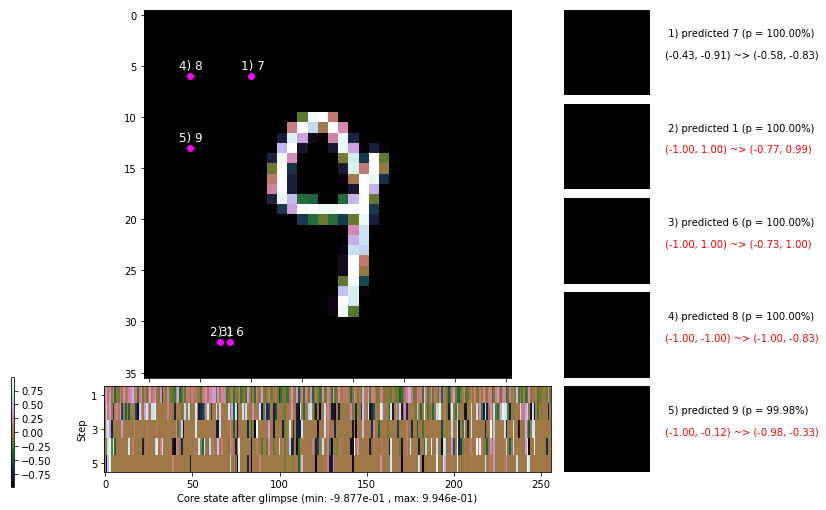

                 --------------------------------------------------------------------------------
 b  45000/ 60000 >> 102.7 ms/b | lr: 6.50e-04 | grad 2norm: 23.38 | grad inf norm:  6.343
         Weights || abs max:  4.058 (20639.512) | mean:  2.722e-04 ( 0.057) | var: 1.632e-01 (218204.875)
          Biases || abs max:  1.969 (   76.255) | mean:  1.104e-02 ( 0.055) | var: 1.671e-01 (  438.584)
                    class loss: 0.961 | steps: 3.991 | reward:  0.746 | acc.: 74.61%
                 --------------------------------------------------------------------------------
 b  60000/ 60000 >> 106.3 ms/b | lr: 6.40e-04 | grad 2norm: 23.21 | grad inf norm:  6.343
         Weights || abs max:  4.098 (16511.551) | mean:  1.391e-04 ( 0.048) | var: 1.677e-01 (76737.953)
          Biases || abs max:  1.897 (  118.011) | mean:  8.780e-03 ( 0.068) | var: 1.681e-01 ( 6979.751)
                    class loss: 0.952 | steps: 3.988 | reward:  0.749 | acc.: 74.87%

	Target class: 0 | Discounted re

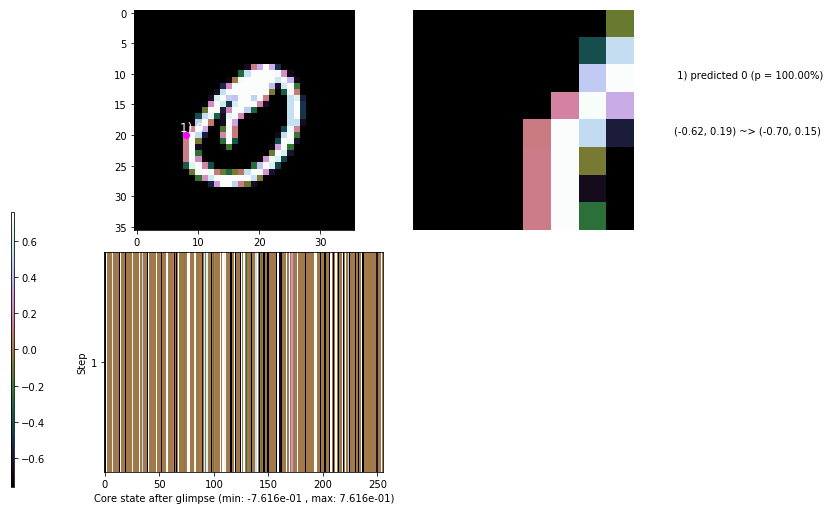

                 --------------------------------------------------------------------------------
                                             ---===  VALIDATION  ===---

	Target class: 2 | Discounted rewards: [0.000, 0.000, 0.000, 0.000, 0.000, 0.000]


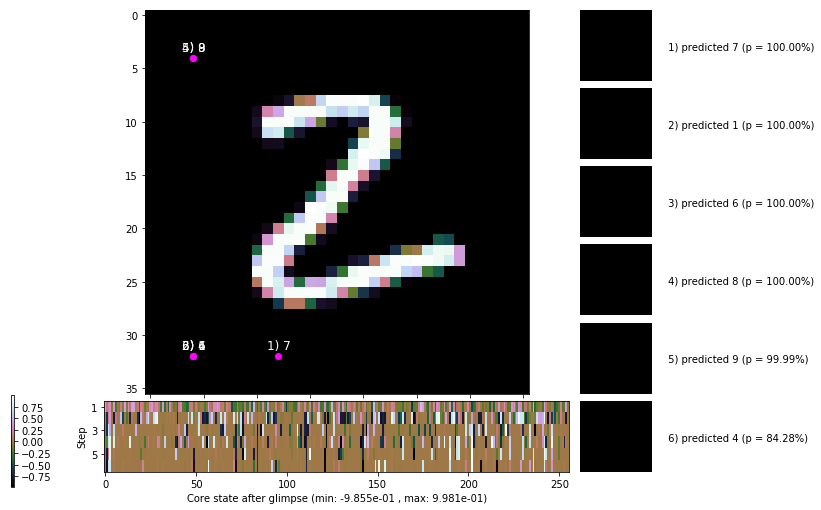


	Target class: 0 | Discounted rewards: [1.000, 1.000, 1.000]


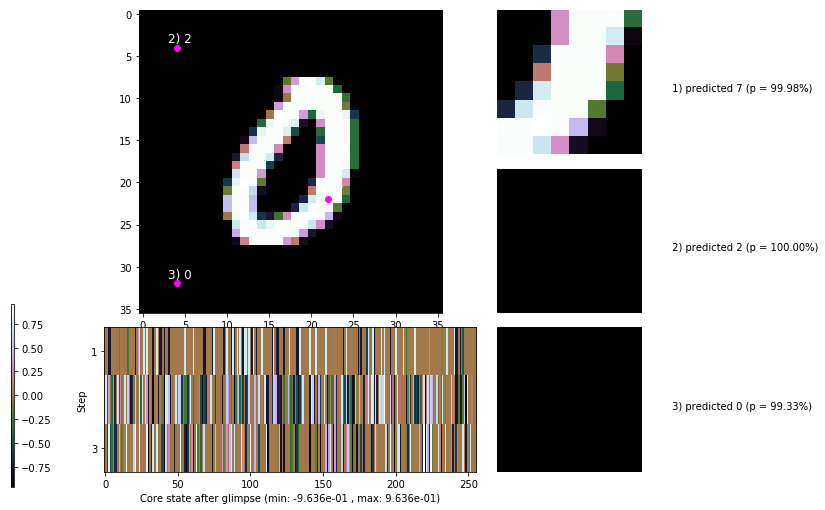

                                       ---===  MODEL PARAM DIAGNOSTICS  ===---


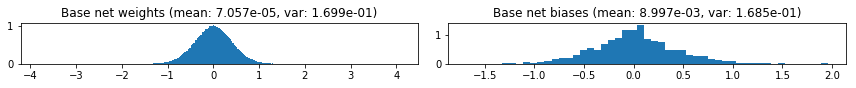

                                         Location network weights and biases


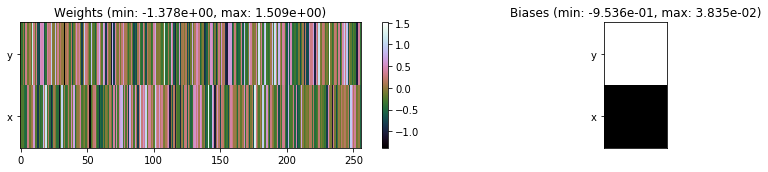

---------------------------------------------------------------------------------------------------------------------
Elapsed time: 6210.72 sec | TRAIN >> class loss: 0.9774 | steps:  4.023    | reward:  0.7379    | acc.: 73.792% 
                          | VAL   >> class loss: 0.9724 | steps:  3.952    | reward:  0.7468    | acc.: 74.680% 


Epoch   7/400) lr = 0.0006369
 b  15000/ 60000 >> 104.0 ms/b | lr: 6.27e-04 | grad 2norm: 22.59 | grad inf norm:  6.355
         Weights || abs max:  4.123 (      inf) | mean: -4.516e-06 (   inf) | var: 1.719e-01 (      nan)
          Biases || abs max:  1.981 (   78.719) | mean:  6.839e-03 ( 0.056) | var: 1.711e-01 (  724.692)
                    class loss: 0.965 | steps: 3.961 | reward:  0.747 | acc.: 74.65%
                 --------------------------------------------------------------------------------
 b  30000/ 60000 >> 103.3 ms/b | lr: 6.15e-04 | grad 2norm: 25.38 | grad inf norm:  6.769
         Weights || abs max:  4.077 (18270.043) | m

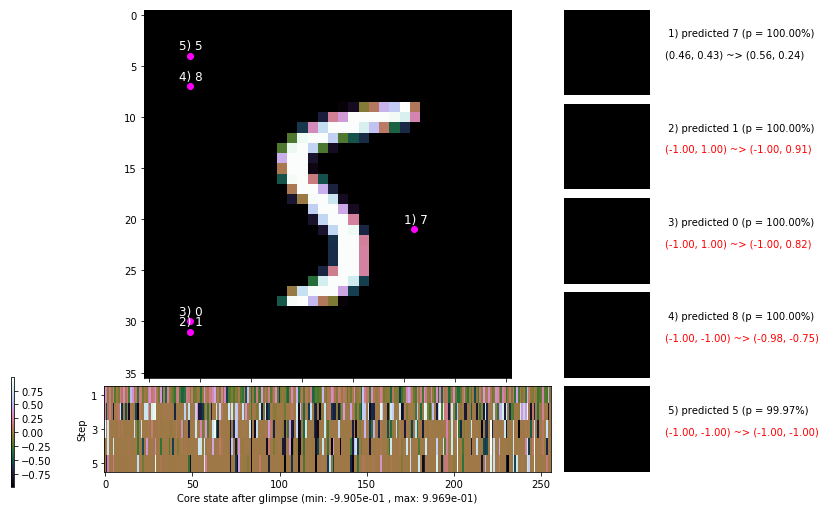

                 --------------------------------------------------------------------------------
 b  45000/ 60000 >> 102.8 ms/b | lr: 6.03e-04 | grad 2norm: 24.85 | grad inf norm:  6.785
         Weights || abs max:  4.061 (13250.584) | mean:  2.639e-05 ( 0.041) | var: 1.801e-01 (42945.090)
          Biases || abs max:  1.951 (  163.785) | mean:  5.983e-03 ( 0.092) | var: 1.759e-01 (20196.156)
                    class loss: 0.930 | steps: 3.957 | reward:  0.724 | acc.: 72.43%
                 --------------------------------------------------------------------------------
 b  60000/ 60000 >> 103.0 ms/b | lr: 5.94e-04 | grad 2norm: 24.06 | grad inf norm:  6.617
         Weights || abs max:  4.032 (28448.570) | mean: -1.143e-04 ( 0.070) | var: 1.839e-01 (2909456.000)
          Biases || abs max:  1.980 (   94.849) | mean:  8.141e-03 ( 0.065) | var: 1.804e-01 ( 2796.783)
                    class loss: 0.937 | steps: 3.931 | reward:  0.733 | acc.: 73.30%

	Target class: 5 | Discounted r

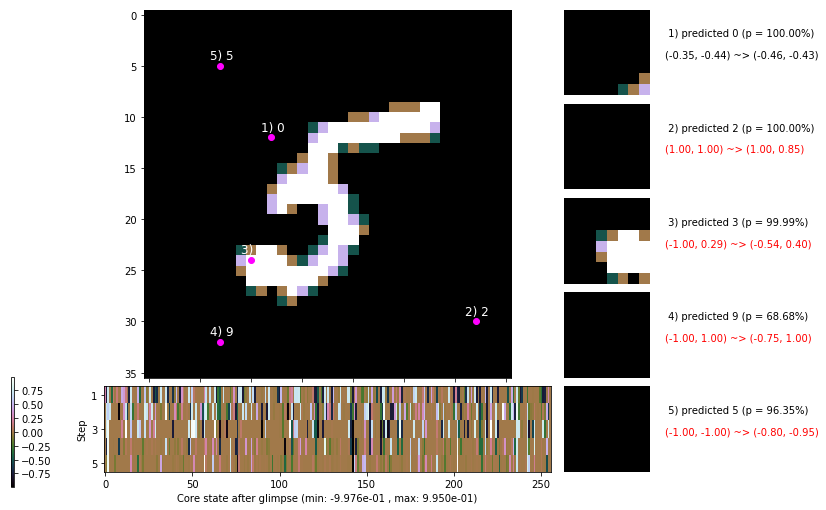

                 --------------------------------------------------------------------------------
                                             ---===  VALIDATION  ===---

	Target class: 7 | Discounted rewards: [0.000, 0.000, 0.000, 0.000, 0.000, 0.000]


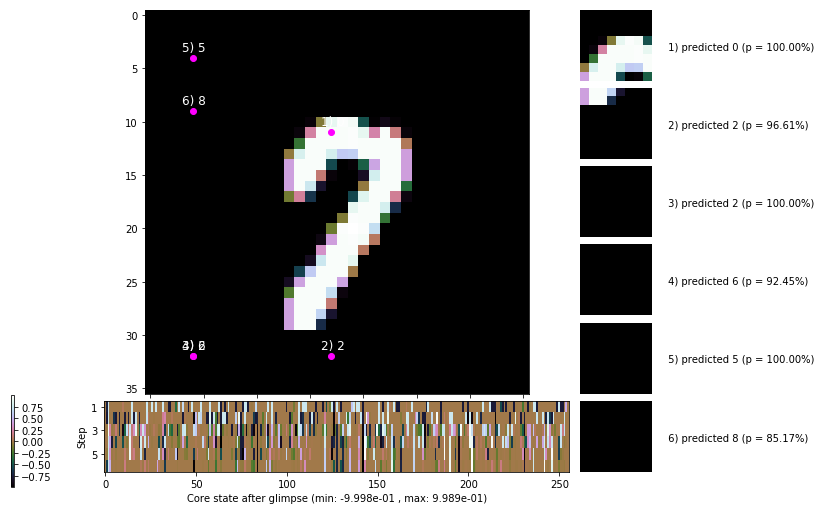


	Target class: 3 | Discounted rewards: [0.000, 0.000, 0.000, 0.000, 0.000, 0.000]


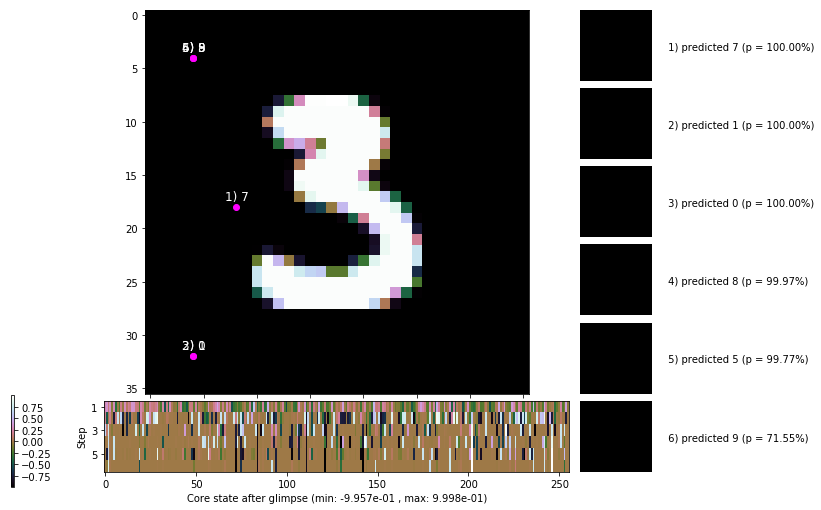

                                       ---===  MODEL PARAM DIAGNOSTICS  ===---


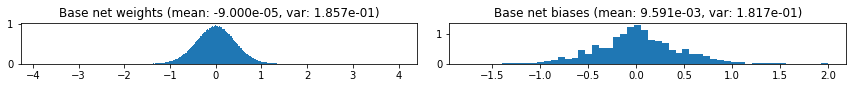

                                         Location network weights and biases


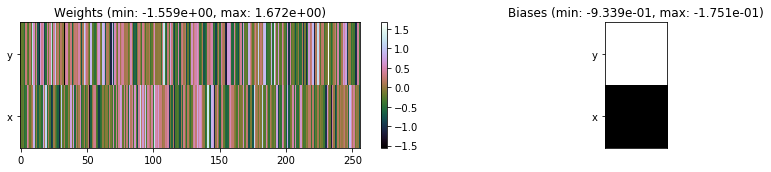

---------------------------------------------------------------------------------------------------------------------
Elapsed time: 6198.71 sec | TRAIN >> class loss: 0.9540 | steps:  3.960    | reward:  0.7340 :( | acc.: 73.402% :(
                          | VAL   >> class loss: 0.9008 | steps:  3.913    | reward:  0.7420 :( | acc.: 74.200% :(


Epoch   8/400) lr = 0.0005908
 b  15000/ 60000 >> 103.0 ms/b | lr: 5.82e-04 | grad 2norm: 24.60 | grad inf norm:  6.707
         Weights || abs max:  3.979 (16637.785) | mean: -1.464e-04 ( 0.049) | var: 1.876e-01 (90206.000)
          Biases || abs max:  2.006 (  107.041) | mean:  8.431e-03 ( 0.071) | var: 1.820e-01 ( 1137.776)
                    class loss: 0.953 | steps: 3.948 | reward:  0.733 | acc.: 73.26%
                 --------------------------------------------------------------------------------
 b  30000/ 60000 >> 102.6 ms/b | lr: 5.70e-04 | grad 2norm: 22.98 | grad inf norm:  6.296
         Weights || abs max:  4.016 (31094.264)

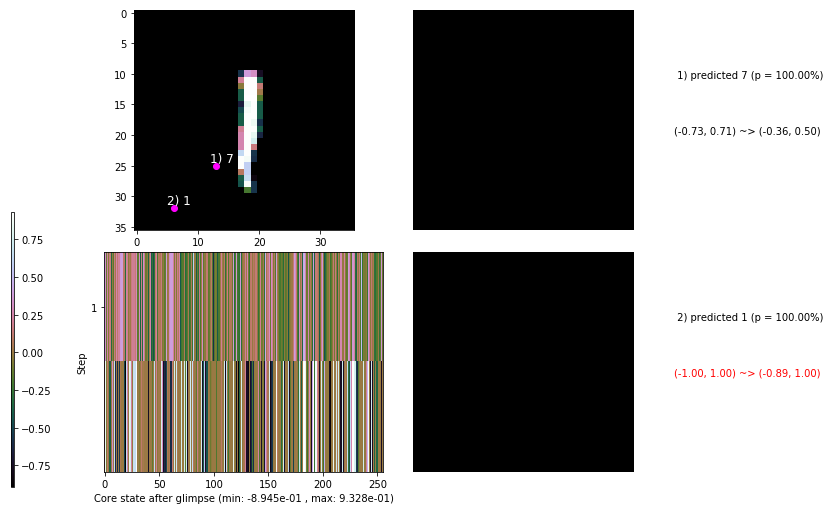

                 --------------------------------------------------------------------------------
 b  45000/ 60000 >> 102.5 ms/b | lr: 5.59e-04 | grad 2norm: 22.96 | grad inf norm:  6.169
         Weights || abs max:  4.042 (18200.199) | mean: -5.790e-05 ( 0.054) | var: 1.945e-01 (149194.719)
          Biases || abs max:  2.127 (   85.491) | mean:  9.921e-03 ( 0.057) | var: 1.871e-01 ( 1621.915)
                    class loss: 0.916 | steps: 3.840 | reward:  0.757 | acc.: 75.69%
                 --------------------------------------------------------------------------------
 b  60000/ 60000 >> 103.4 ms/b | lr: 5.51e-04 | grad 2norm: 24.56 | grad inf norm:  6.499
         Weights || abs max:  4.113 (17559.844) | mean: -3.138e-05 ( 0.051) | var: 1.979e-01 (132872.172)
          Biases || abs max:  2.105 (   69.925) | mean:  7.627e-03 ( 0.053) | var: 1.889e-01 (  257.555)
                    class loss: 0.936 | steps: 3.890 | reward:  0.743 | acc.: 74.27%

	Target class: 6 | Discounted r

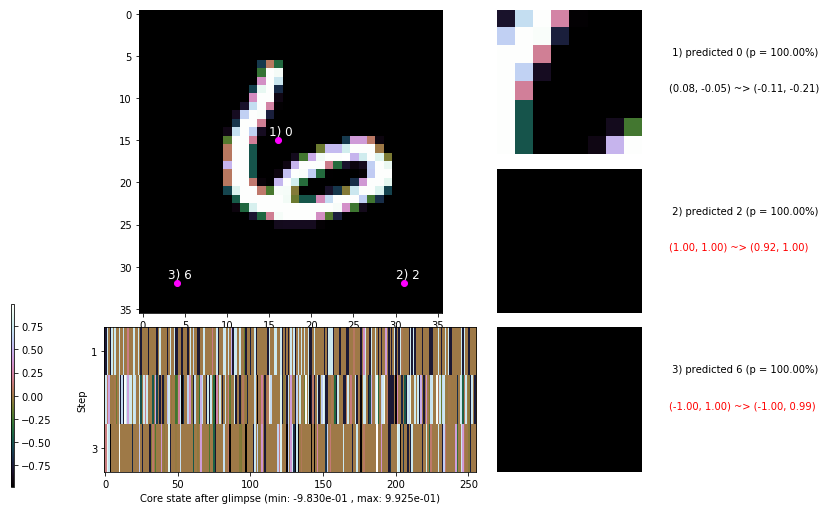

                 --------------------------------------------------------------------------------
                                             ---===  VALIDATION  ===---

	Target class: 1 | Discounted rewards: [1.000, 1.000]


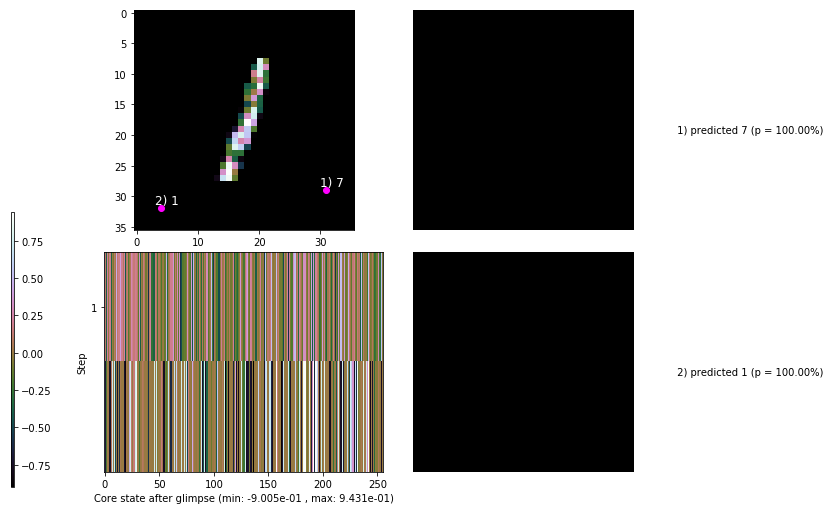


	Target class: 8 | Discounted rewards: [0.000, 0.000, 0.000, 0.000, 0.000, 0.000]


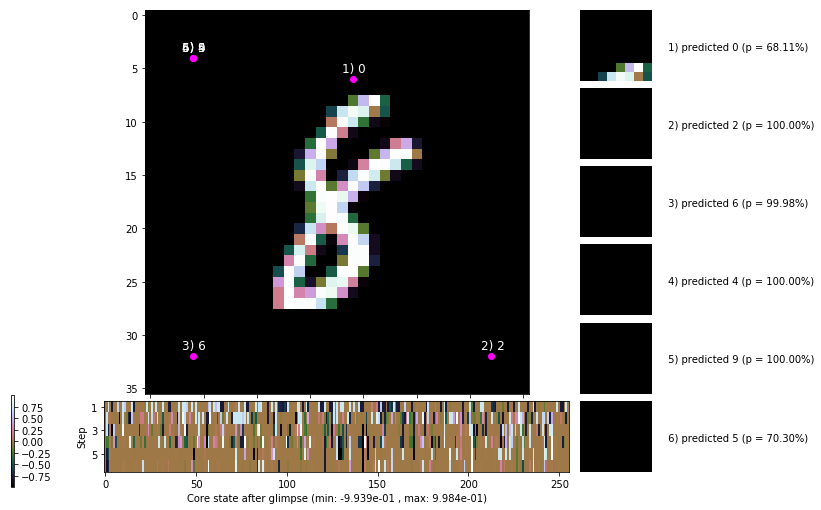

                                       ---===  MODEL PARAM DIAGNOSTICS  ===---


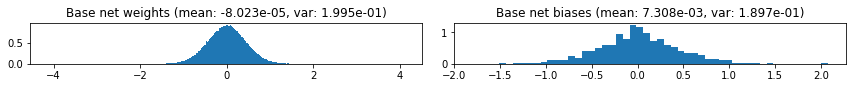

                                         Location network weights and biases


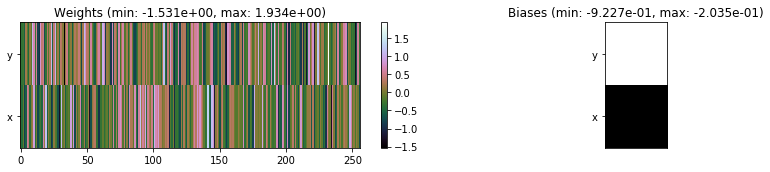

---------------------------------------------------------------------------------------------------------------------
Elapsed time: 6173.98 sec | TRAIN >> class loss: 0.9367 | steps:  3.893    | reward:  0.7457    | acc.: 74.565% 
                          | VAL   >> class loss: 0.9473 | steps:  3.830    | reward:  0.7578    | acc.: 75.780% 


Epoch   9/400) lr = 0.000548
 b  15000/ 60000 >> 102.5 ms/b | lr: 5.40e-04 | grad 2norm: 26.39 | grad inf norm:  6.809
         Weights || abs max:  4.161 (13065.430) | mean: -1.563e-04 ( 0.042) | var: 2.011e-01 (23219.070)
          Biases || abs max:  2.069 (   61.263) | mean:  5.837e-03 ( 0.051) | var: 1.900e-01 (  103.206)
                    class loss: 0.957 | steps: 3.899 | reward:  0.736 | acc.: 73.64%
                 --------------------------------------------------------------------------------
 b  30000/ 60000 >> 102.5 ms/b | lr: 5.29e-04 | grad 2norm: 25.67 | grad inf norm:  6.734
         Weights || abs max:  4.211 (18037.945) | me

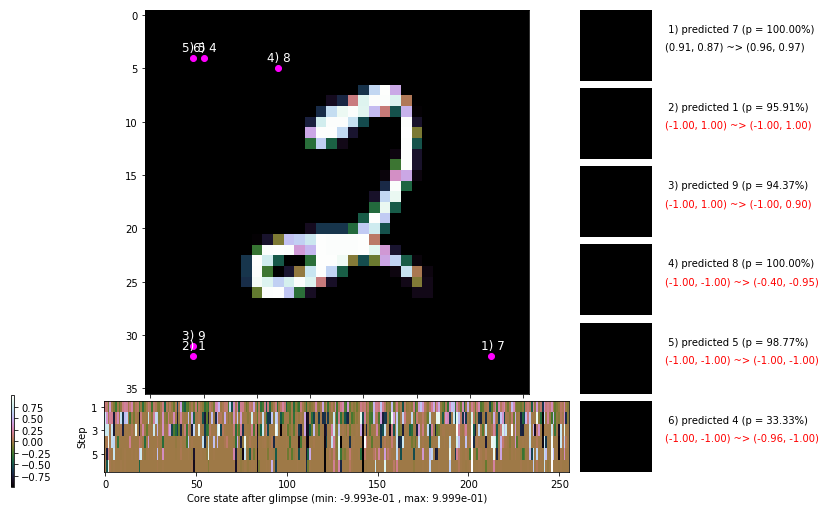

                 --------------------------------------------------------------------------------
 b  45000/ 60000 >> 102.7 ms/b | lr: 5.19e-04 | grad 2norm: 24.17 | grad inf norm:  6.556
         Weights || abs max:  4.239 (24377.131) | mean: -4.249e-04 ( 0.060) | var: 2.071e-01 (3127981.000)
          Biases || abs max:  2.067 (  104.179) | mean:  2.683e-03 ( 0.067) | var: 1.955e-01 ( 4596.861)
                    class loss: 0.859 | steps: 3.865 | reward:  0.734 | acc.: 73.41%
                 --------------------------------------------------------------------------------
 b  60000/ 60000 >> 102.7 ms/b | lr: 5.11e-04 | grad 2norm: 23.21 | grad inf norm:  6.299
         Weights || abs max:  4.318 (21385.744) | mean: -5.334e-04 ( 0.056) | var: 2.100e-01 (1210989.500)
          Biases || abs max:  2.104 (   71.003) | mean:  5.478e-03 ( 0.055) | var: 1.975e-01 (  401.423)
                    class loss: 0.853 | steps: 3.839 | reward:  0.747 | acc.: 74.69%

	Target class: 1 | Discounted

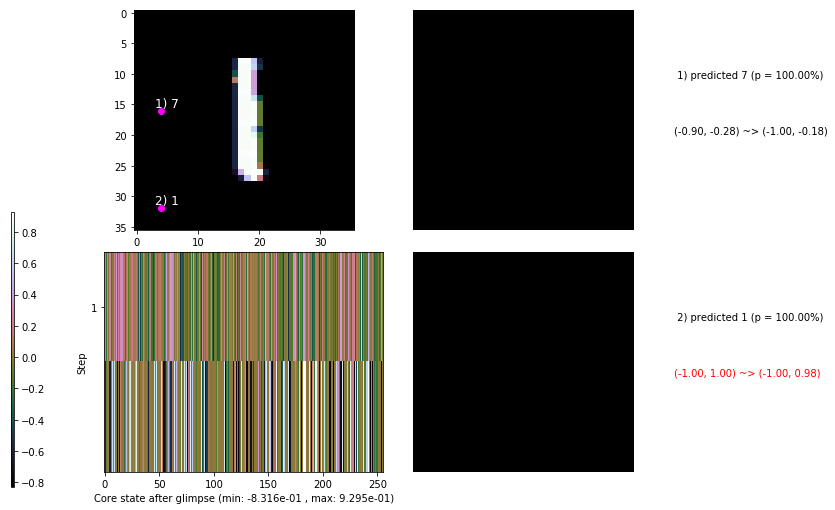

                 --------------------------------------------------------------------------------
                                             ---===  VALIDATION  ===---

	Target class: 8 | Discounted rewards: [1.000, 1.000, 1.000, 1.000]


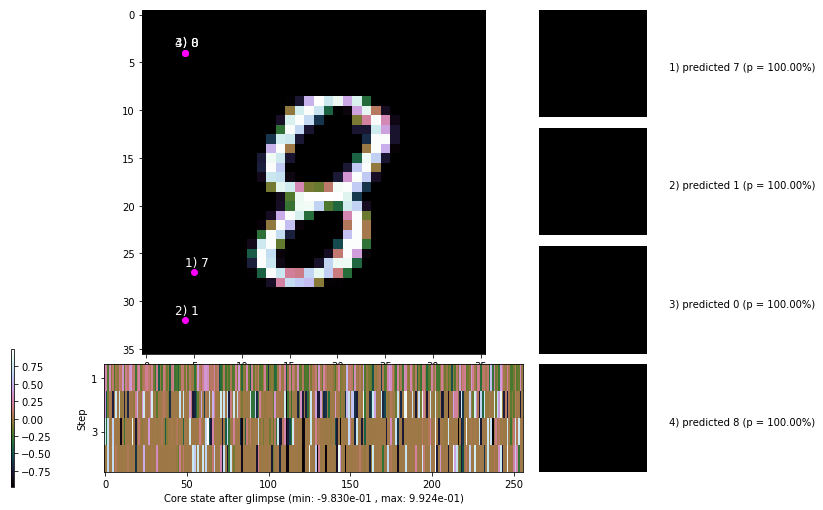


	Target class: 2 | Discounted rewards: [0.000, 0.000, 0.000, 0.000, 0.000, 0.000]


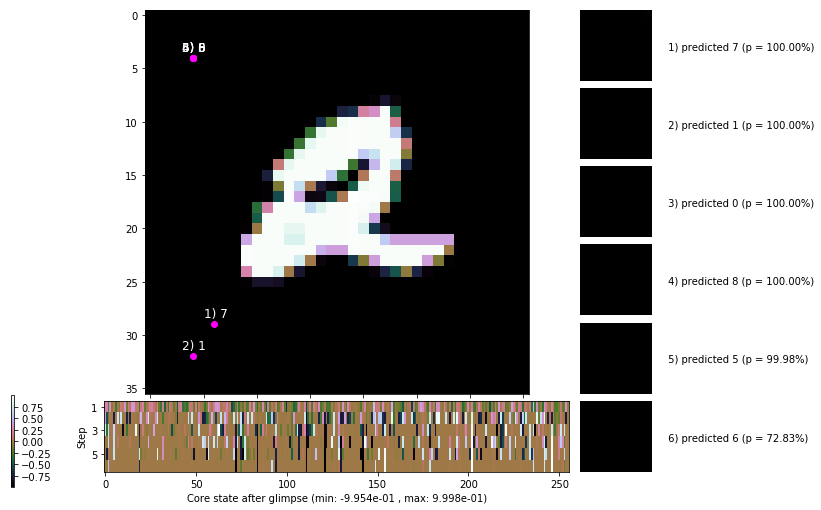

                                       ---===  MODEL PARAM DIAGNOSTICS  ===---


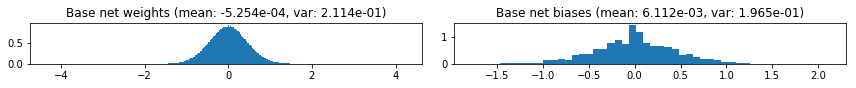

                                         Location network weights and biases


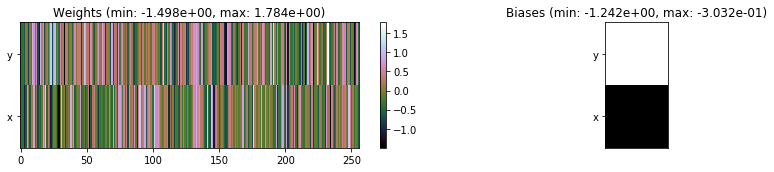

---------------------------------------------------------------------------------------------------------------------
Elapsed time: 6156.62 sec | TRAIN >> class loss: 0.8889 | steps:  3.868    | reward:  0.7379 :( | acc.: 73.787% :(
                          | VAL   >> class loss: 0.8275 | steps:  3.788    | reward:  0.7564 :( | acc.: 75.640% :(


Epoch  10/400) lr = 0.0005083
 b  15000/ 60000 >> 102.9 ms/b | lr: 5.01e-04 | grad 2norm: 24.84 | grad inf norm:  6.543
         Weights || abs max:  4.369 (26754.117) | mean: -4.931e-04 ( 0.066) | var: 2.128e-01 (4583268.000)
          Biases || abs max:  2.081 (  391.026) | mean:  6.100e-03 ( 0.182) | var: 1.969e-01 (482417.062)
                    class loss: 0.877 | steps: 3.864 | reward:  0.742 | acc.: 74.15%
                 --------------------------------------------------------------------------------
 b  30000/ 60000 >> 102.5 ms/b | lr: 4.91e-04 | grad 2norm: 24.32 | grad inf norm:  6.387
         Weights || abs max:  4.443 (17284.2

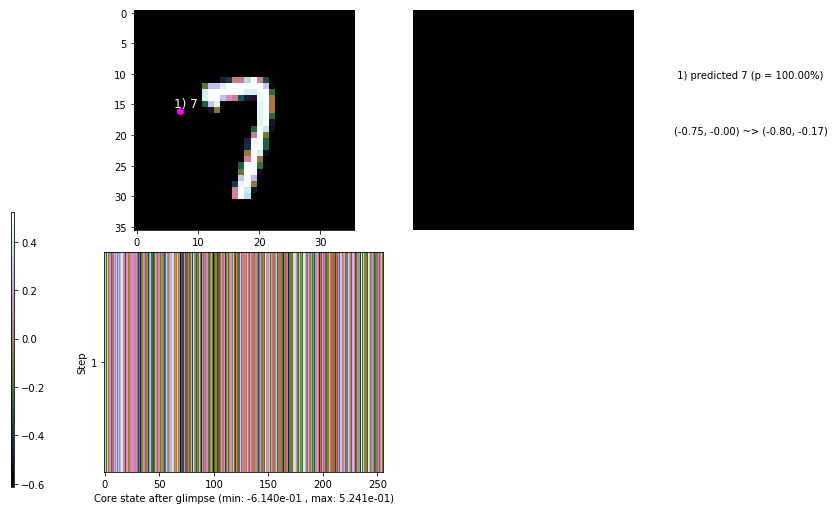

                 --------------------------------------------------------------------------------
 b  45000/ 60000 >> 105.3 ms/b | lr: 4.81e-04 | grad 2norm: 24.28 | grad inf norm:  6.477
         Weights || abs max:  4.430 (14610.582) | mean: -3.661e-04 ( 0.045) | var: 2.181e-01 (90654.578)
          Biases || abs max:  2.086 (  145.095) | mean:  6.000e-03 ( 0.088) | var: 2.007e-01 ( 8706.425)
                    class loss: 0.853 | steps: 3.837 | reward:  0.740 | acc.: 74.00%
                 --------------------------------------------------------------------------------
 b  60000/ 60000 >> 105.9 ms/b | lr: 4.74e-04 | grad 2norm: 24.24 | grad inf norm:  6.375
         Weights || abs max:  4.496 (15135.408) | mean: -4.583e-04 ( 0.046) | var: 2.207e-01 (126524.273)
          Biases || abs max:  2.113 (  117.749) | mean:  6.804e-03 ( 0.080) | var: 2.028e-01 ( 2612.089)
                    class loss: 0.850 | steps: 3.816 | reward:  0.745 | acc.: 74.52%

	Target class: 1 | Discounted re

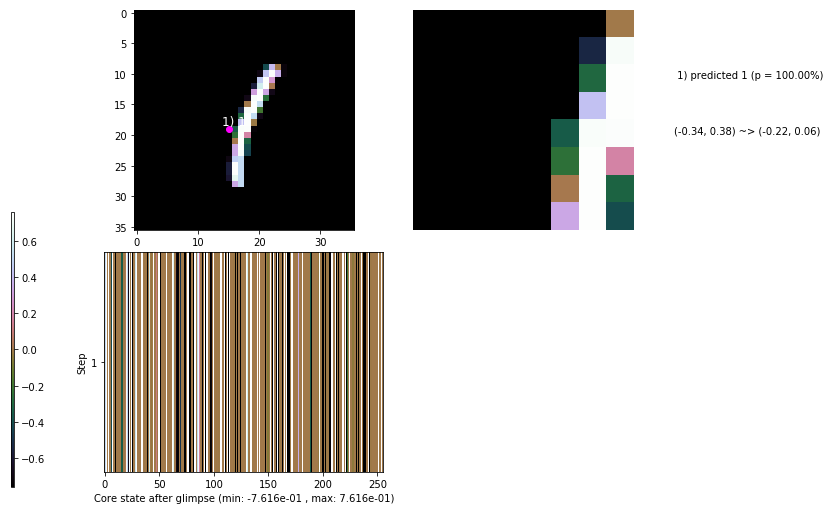

                 --------------------------------------------------------------------------------
                                             ---===  VALIDATION  ===---

	Target class: 1 | Discounted rewards: [1.000, 1.000]


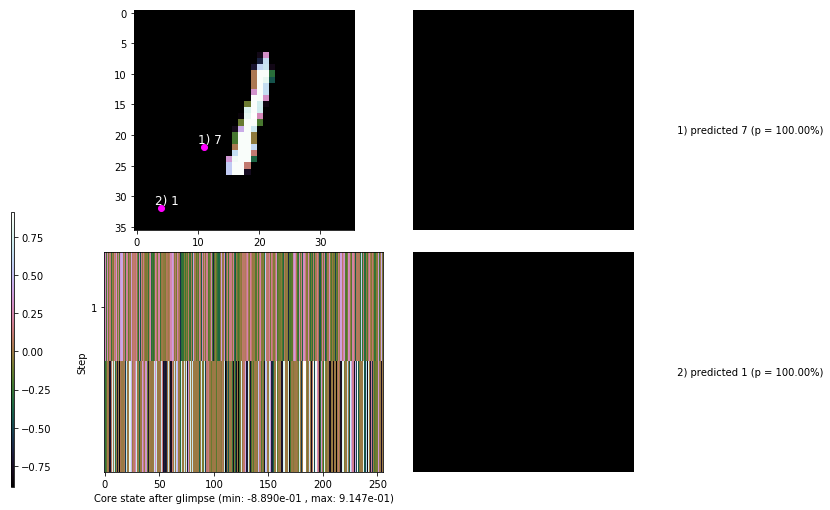


	Target class: 2 | Discounted rewards: [1.000, 1.000]


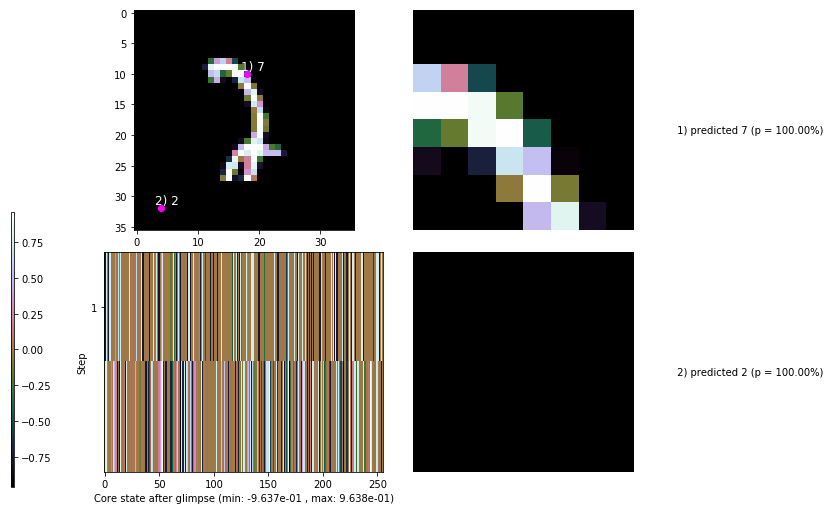

                                       ---===  MODEL PARAM DIAGNOSTICS  ===---


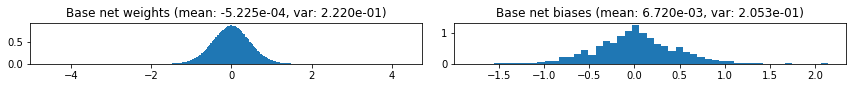

                                         Location network weights and biases


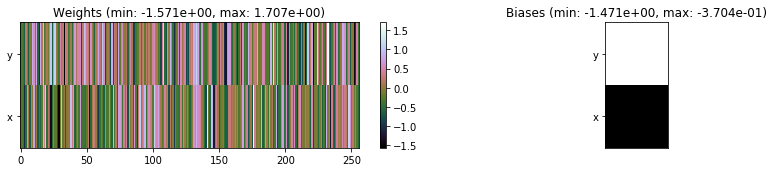

---------------------------------------------------------------------------------------------------------------------
Elapsed time: 6249.85 sec | TRAIN >> class loss: 0.8638 | steps:  3.835    | reward:  0.7443 :( | acc.: 74.428% :(
                          | VAL   >> class loss: 0.8859 | steps:  3.809 :( | reward:  0.7470 :( | acc.: 74.700% :(


Epoch  11/400) lr = 0.0004715
 b  15000/ 60000 >> 102.4 ms/b | lr: 4.64e-04 | grad 2norm: 24.76 | grad inf norm:  6.447
         Weights || abs max:  4.569 (20195.072) | mean: -5.782e-04 ( 0.057) | var: 2.232e-01 (257396.594)
          Biases || abs max:  2.121 (  151.452) | mean:  5.742e-03 ( 0.100) | var: 2.065e-01 ( 1797.370)
                    class loss: 0.912 | steps: 3.825 | reward:  0.749 | acc.: 74.91%
                 --------------------------------------------------------------------------------
 b  30000/ 60000 >> 102.3 ms/b | lr: 4.55e-04 | grad 2norm: 21.90 | grad inf norm:  5.934
         Weights || abs max:  4.617 (18714.891

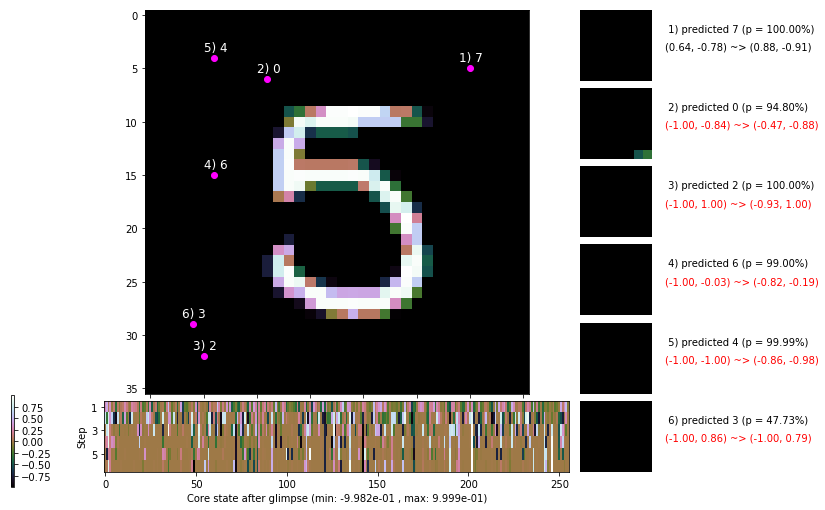

                 --------------------------------------------------------------------------------
 b  45000/ 60000 >> 102.3 ms/b | lr: 4.46e-04 | grad 2norm: 22.33 | grad inf norm:  5.983
         Weights || abs max:  4.588 (18755.961) | mean: -6.400e-04 ( 0.056) | var: 2.278e-01 (75427.688)
          Biases || abs max:  2.126 (  127.053) | mean:  6.425e-03 ( 0.087) | var: 2.082e-01 ( 3044.981)
                    class loss: 0.899 | steps: 3.771 | reward:  0.768 | acc.: 76.85%
                 --------------------------------------------------------------------------------
 b  60000/ 60000 >> 102.3 ms/b | lr: 4.40e-04 | grad 2norm: 22.92 | grad inf norm:  5.993
         Weights || abs max:  4.618 (26448.695) | mean: -6.714e-04 ( 0.069) | var: 2.299e-01 (2558461.750)
          Biases || abs max:  2.163 (  108.425) | mean:  5.852e-03 ( 0.078) | var: 2.105e-01 (  971.017)
                    class loss: 0.848 | steps: 3.733 | reward:  0.766 | acc.: 76.59%

	Target class: 2 | Discounted r

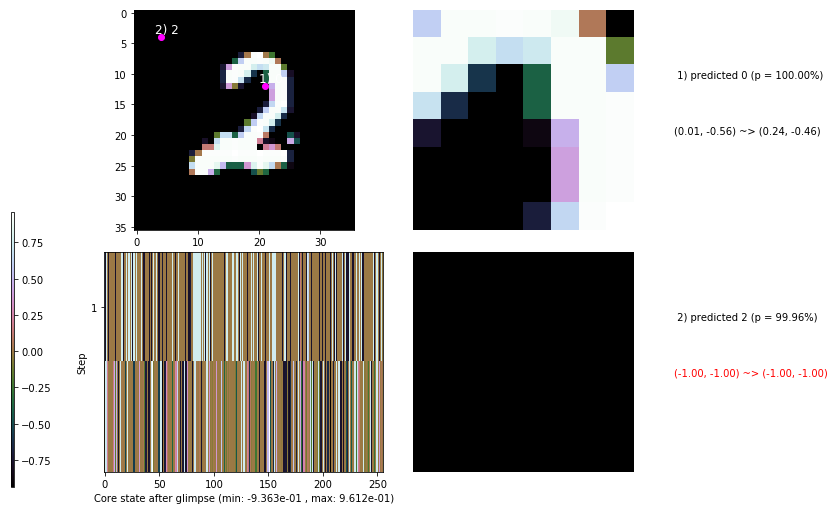

                 --------------------------------------------------------------------------------
                                             ---===  VALIDATION  ===---

	Target class: 9 | Discounted rewards: [1.000, 1.000, 1.000, 1.000, 1.000]


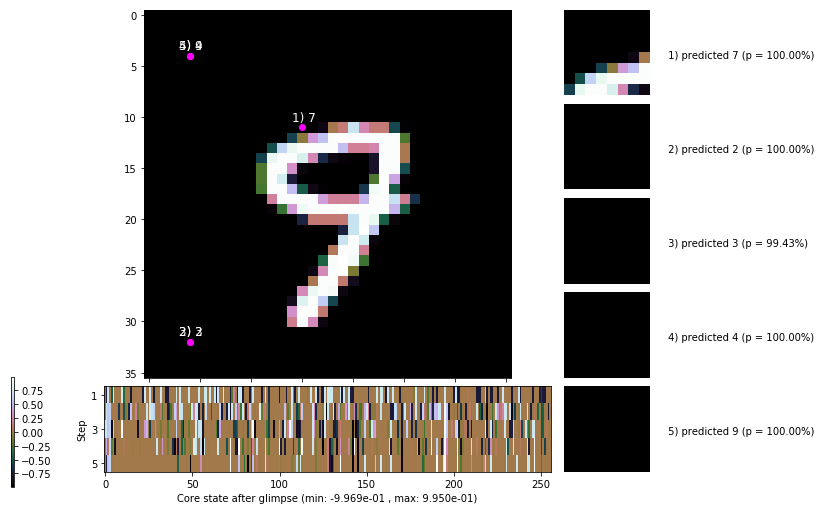


	Target class: 8 | Discounted rewards: [1.000, 1.000, 1.000, 1.000, 1.000]


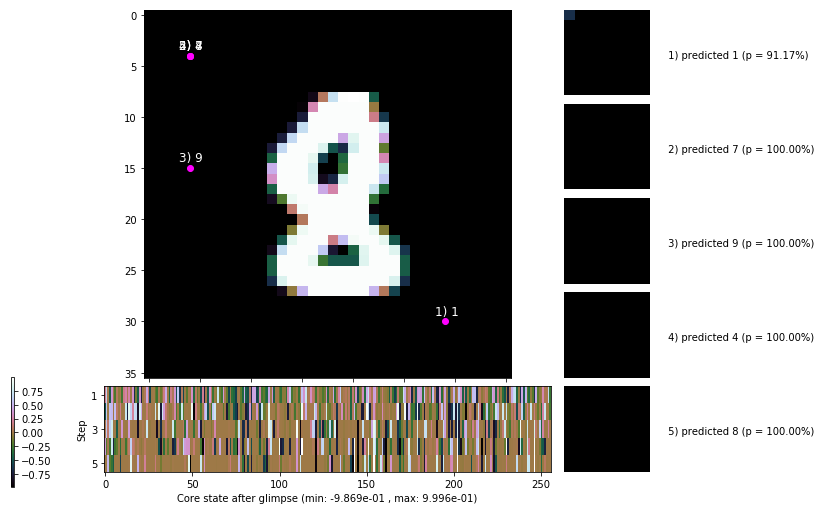

                                       ---===  MODEL PARAM DIAGNOSTICS  ===---


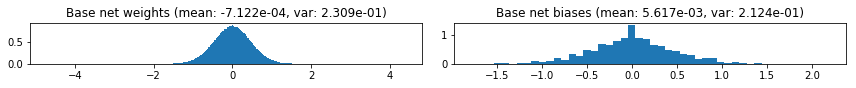

                                         Location network weights and biases


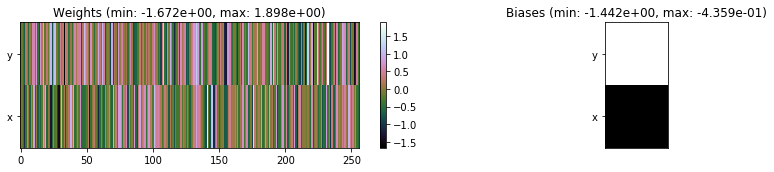

---------------------------------------------------------------------------------------------------------------------
Elapsed time: 6139.82 sec | TRAIN >> class loss: 0.8866 | steps:  3.773    | reward:  0.7629    | acc.: 76.287% 
                          | VAL   >> class loss: 0.8037 | steps:  3.739    | reward:  0.7650    | acc.: 76.500% 


Epoch  12/400) lr = 0.0004373
 b  15000/ 60000 >> 102.2 ms/b | lr: 4.31e-04 | grad 2norm: 22.59 | grad inf norm:  5.865
         Weights || abs max:  4.656 (25984.439) | mean: -6.752e-04 ( 0.069) | var: 2.319e-01 (1354098.875)
          Biases || abs max:  2.140 (  534.911) | mean:  5.323e-03 ( 0.240) | var: 2.125e-01 (1079451.875)
                    class loss: 0.822 | steps: 3.689 | reward:  0.772 | acc.: 77.22%
                 --------------------------------------------------------------------------------
 b  30000/ 60000 >> 102.4 ms/b | lr: 4.22e-04 | grad 2norm: 23.45 | grad inf norm:  6.061
         Weights || abs max:  4.674 (21633.137)

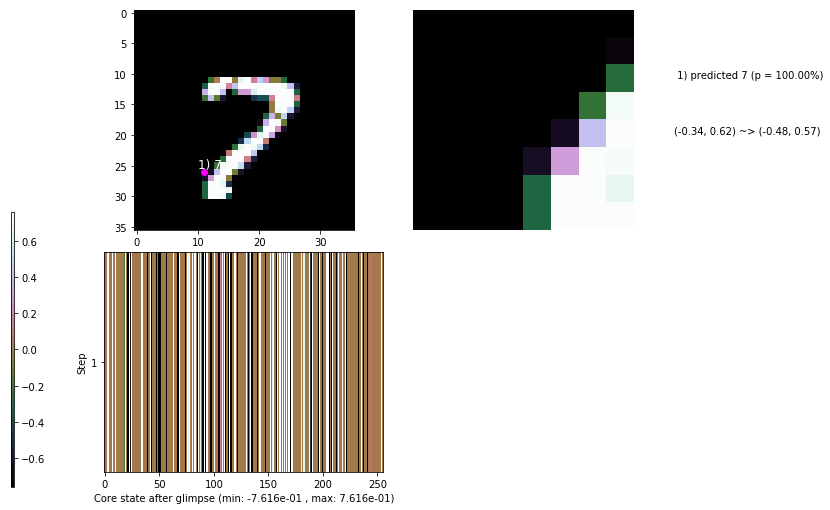

                 --------------------------------------------------------------------------------
 b  45000/ 60000 >> 102.6 ms/b | lr: 4.14e-04 | grad 2norm: 22.82 | grad inf norm:  6.040
         Weights || abs max:  4.689 (34237.930) | mean: -6.465e-04 ( 0.083) | var: 2.357e-01 (3662028.500)
          Biases || abs max:  2.107 (  265.267) | mean:  2.743e-03 ( 0.137) | var: 2.135e-01 (130743.289)
                    class loss: 0.863 | steps: 3.763 | reward:  0.764 | acc.: 76.41%
                 --------------------------------------------------------------------------------
 b  60000/ 60000 >> 104.1 ms/b | lr: 4.08e-04 | grad 2norm: 22.17 | grad inf norm:  5.943
         Weights || abs max:  4.786 (15559.563) | mean: -7.037e-04 ( 0.049) | var: 2.375e-01 (33250.305)
          Biases || abs max:  2.154 (   88.096) | mean:  2.955e-03 ( 0.066) | var: 2.144e-01 (  618.924)
                    class loss: 0.815 | steps: 3.698 | reward:  0.771 | acc.: 77.07%

	Target class: 5 | Discounted 

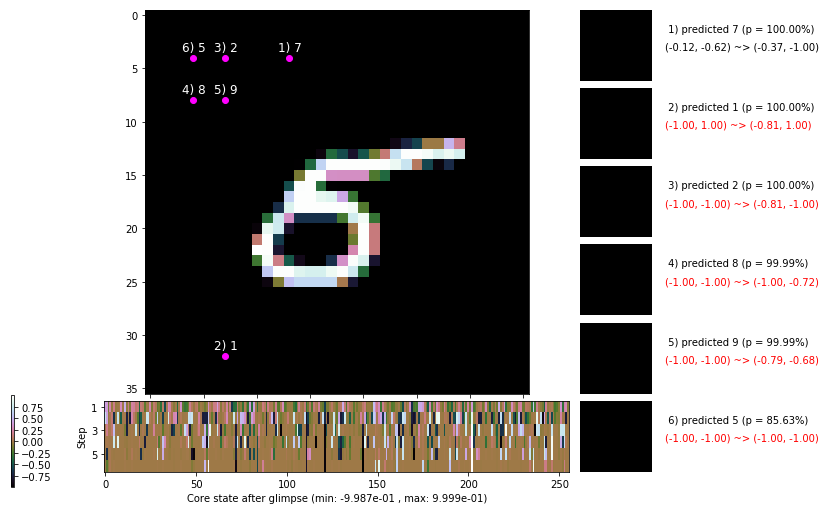

                 --------------------------------------------------------------------------------
                                             ---===  VALIDATION  ===---

	Target class: 4 | Discounted rewards: [1.000, 1.000, 1.000, 1.000]


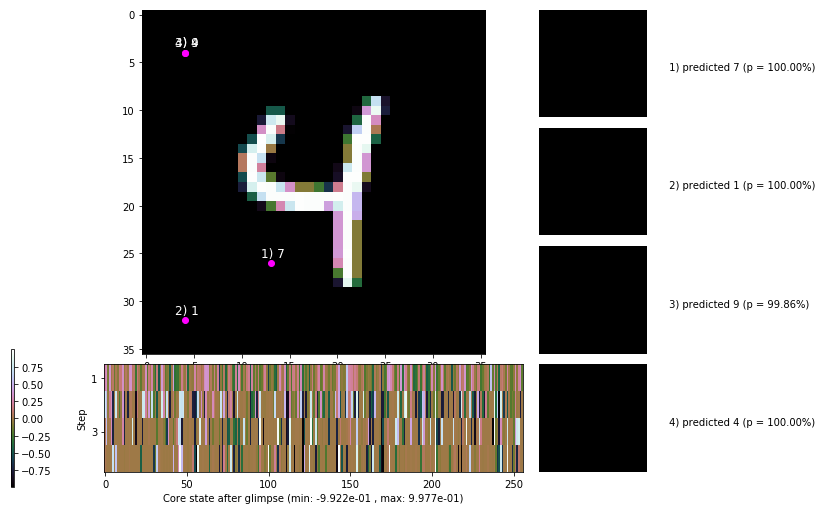


	Target class: 3 | Discounted rewards: [1.000]


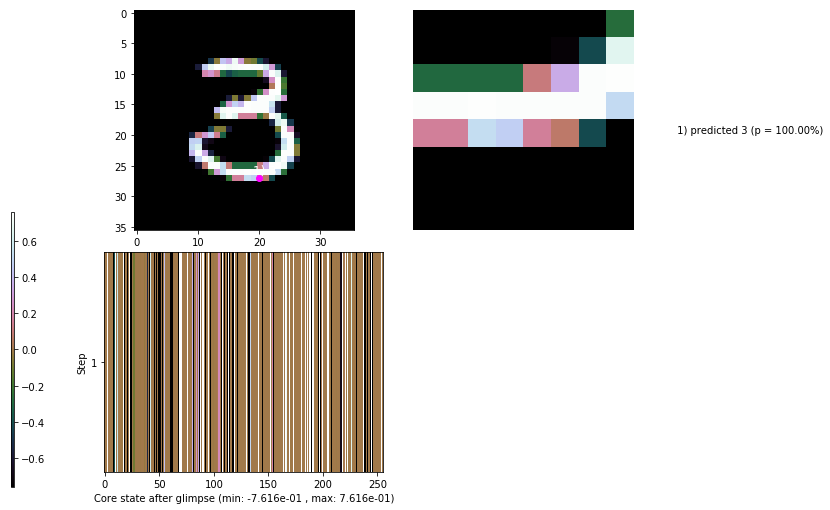

                                       ---===  MODEL PARAM DIAGNOSTICS  ===---


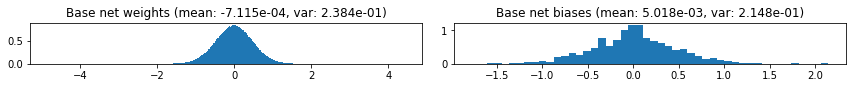

                                         Location network weights and biases


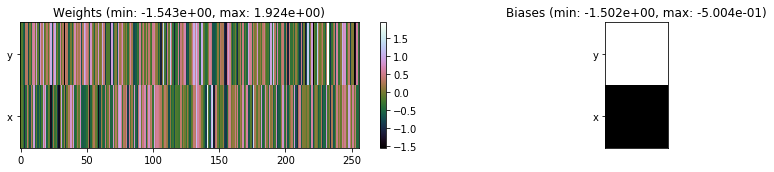

---------------------------------------------------------------------------------------------------------------------
Elapsed time: 6171.57 sec | TRAIN >> class loss: 0.8408 | steps:  3.724    | reward:  0.7685    | acc.: 76.850% 
                          | VAL   >> class loss: 0.8374 | steps:  3.671    | reward:  0.7714    | acc.: 77.140% 


Epoch  13/400) lr = 0.0004057
 b  15000/ 60000 >> 105.0 ms/b | lr: 4.00e-04 | grad 2norm: 22.48 | grad inf norm:  5.974
         Weights || abs max:  4.828 (24484.920) | mean: -7.150e-04 ( 0.067) | var: 2.392e-01 (868768.312)
          Biases || abs max:  2.138 (  143.983) | mean:  4.454e-03 ( 0.089) | var: 2.161e-01 ( 6019.682)
                    class loss: 0.829 | steps: 3.702 | reward:  0.766 | acc.: 76.64%
                 --------------------------------------------------------------------------------
 b  30000/ 60000 >> 104.4 ms/b | lr: 3.92e-04 | grad 2norm: 21.85 | grad inf norm:  5.736
         Weights || abs max:  4.823 (23988.246) | 

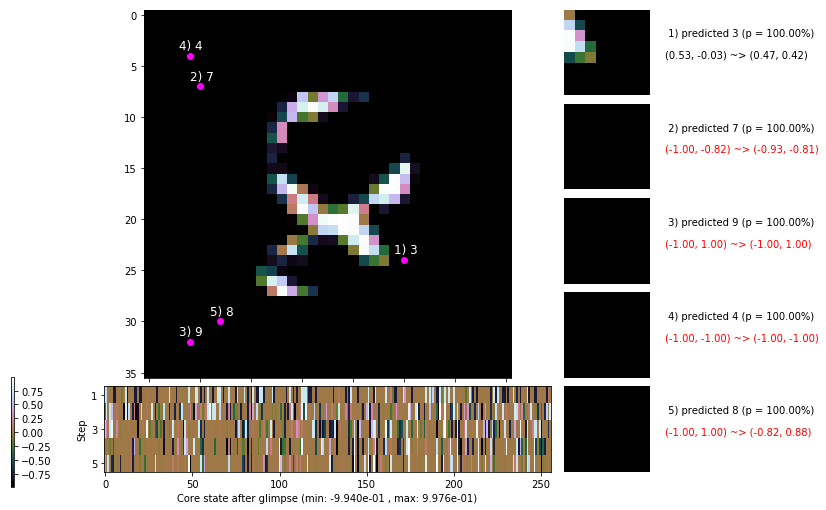

                 --------------------------------------------------------------------------------
 b  45000/ 60000 >> 104.8 ms/b | lr: 3.84e-04 | grad 2norm: 21.99 | grad inf norm:  5.826
         Weights || abs max:  4.884 (21449.779) | mean: -7.324e-04 ( 0.063) | var: 2.424e-01 (124421.070)
          Biases || abs max:  2.089 (  118.852) | mean:  2.951e-03 ( 0.077) | var: 2.181e-01 ( 2904.070)
                    class loss: 0.836 | steps: 3.667 | reward:  0.778 | acc.: 77.76%
                 --------------------------------------------------------------------------------
 b  60000/ 60000 >> 106.0 ms/b | lr: 3.78e-04 | grad 2norm: 21.84 | grad inf norm:  5.759
         Weights || abs max:  4.909 (18454.369) | mean: -7.202e-04 ( 0.058) | var: 2.440e-01 (61840.246)
          Biases || abs max:  2.074 (  112.921) | mean:  2.916e-03 ( 0.082) | var: 2.178e-01 (  833.154)
                    class loss: 0.868 | steps: 3.697 | reward:  0.779 | acc.: 77.89%

	Target class: 6 | Discounted re

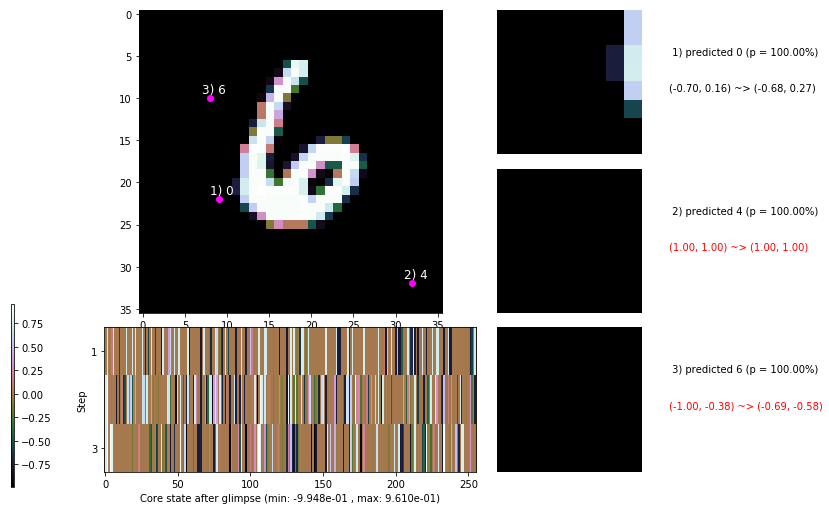

                 --------------------------------------------------------------------------------
                                             ---===  VALIDATION  ===---

	Target class: 5 | Discounted rewards: [1.000, 1.000, 1.000, 1.000, 1.000, 1.000]


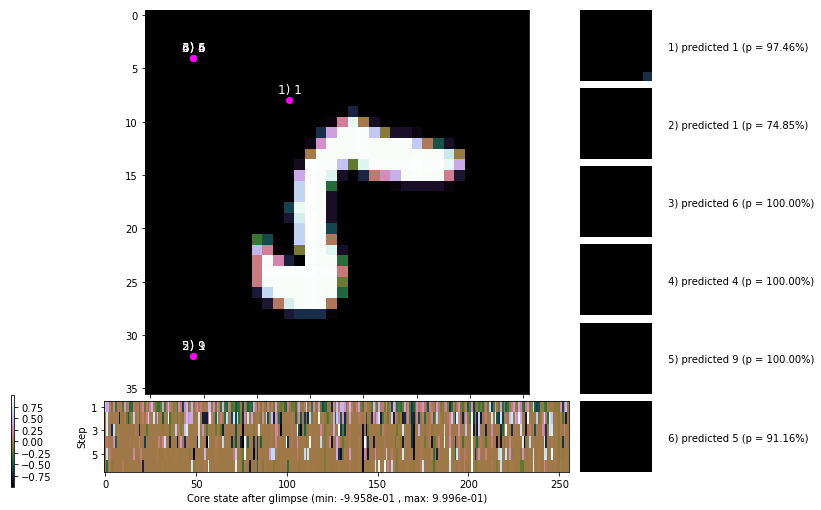


	Target class: 2 | Discounted rewards: [1.000, 1.000]


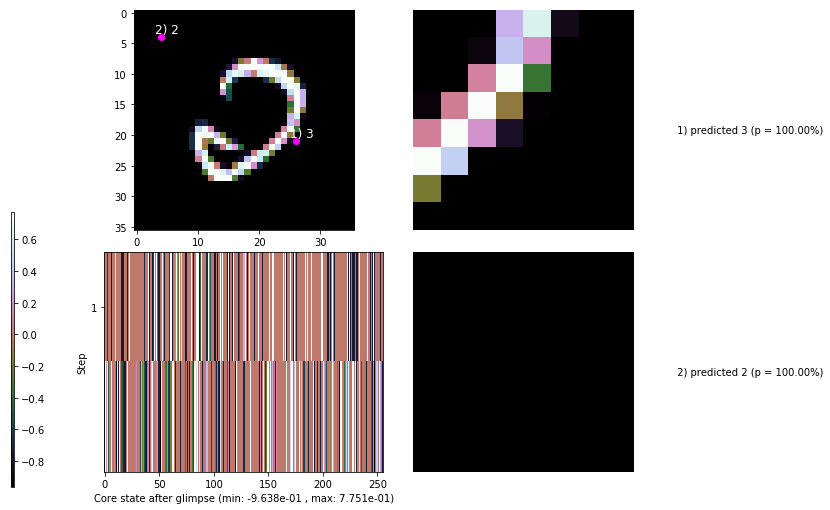

                                       ---===  MODEL PARAM DIAGNOSTICS  ===---


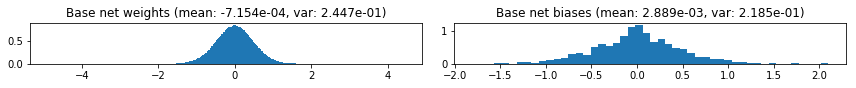

                                         Location network weights and biases


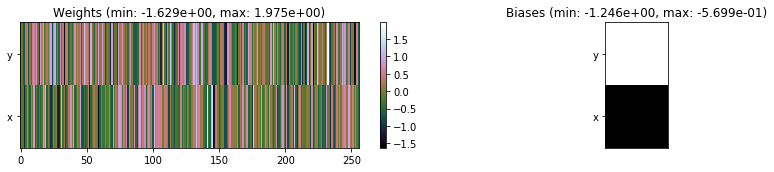

---------------------------------------------------------------------------------------------------------------------
Elapsed time: 6304.14 sec | TRAIN >> class loss: 0.8269 | steps:  3.680    | reward:  0.7746    | acc.: 77.465% 
                          | VAL   >> class loss: 0.8046 | steps:  3.633    | reward:  0.7824    | acc.: 78.240% 


Epoch  14/400) lr = 0.0003763
 b  15000/ 60000 >> 104.9 ms/b | lr: 3.71e-04 | grad 2norm: 22.64 | grad inf norm:  5.722
         Weights || abs max:  4.901 (19019.496) | mean: -7.280e-04 ( 0.060) | var: 2.454e-01 (140047.797)
          Biases || abs max:  2.085 (  163.333) | mean:  4.528e-03 ( 0.101) | var: 2.192e-01 ( 5456.240)
                    class loss: 0.838 | steps: 3.631 | reward:  0.789 | acc.: 78.92%
                 --------------------------------------------------------------------------------
 b  30000/ 60000 >> 105.1 ms/b | lr: 3.63e-04 | grad 2norm: 21.96 | grad inf norm:  5.677
         Weights || abs max:  4.920 (25088.584) | 

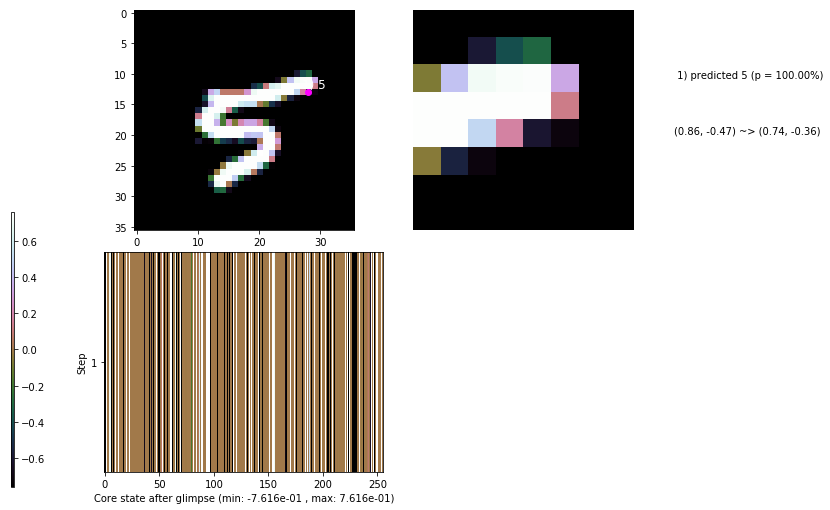

                 --------------------------------------------------------------------------------
 b  45000/ 60000 >> 105.7 ms/b | lr: 3.56e-04 | grad 2norm: 23.58 | grad inf norm:  6.044
         Weights || abs max:  4.930 (30399.564) | mean: -7.556e-04 ( 0.079) | var: 2.483e-01 (1007880.500)
          Biases || abs max:  2.086 (  175.038) | mean:  4.506e-03 ( 0.114) | var: 2.197e-01 ( 5783.120)
                    class loss: 0.858 | steps: 3.684 | reward:  0.772 | acc.: 77.21%
                 --------------------------------------------------------------------------------
 b  60000/ 60000 >> 114.1 ms/b | lr: 3.51e-04 | grad 2norm: 23.00 | grad inf norm:  5.976
         Weights || abs max:  4.965 (17870.236) | mean: -8.603e-04 ( 0.056) | var: 2.497e-01 (133787.672)
          Biases || abs max:  2.075 (  218.131) | mean:  4.258e-03 ( 0.129) | var: 2.206e-01 (26833.320)
                    class loss: 0.838 | steps: 3.693 | reward:  0.773 | acc.: 77.33%

	Target class: 7 | Discounted 

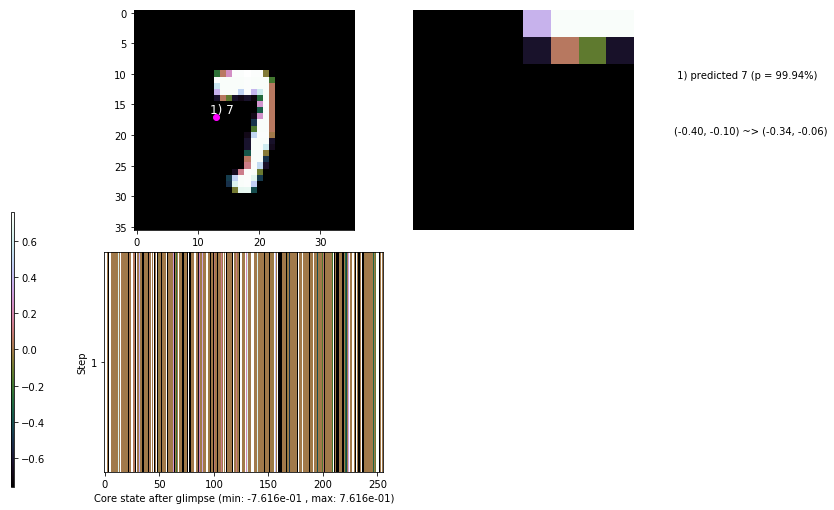

                 --------------------------------------------------------------------------------
                                             ---===  VALIDATION  ===---

	Target class: 9 | Discounted rewards: [1.000, 1.000, 1.000, 1.000, 1.000]


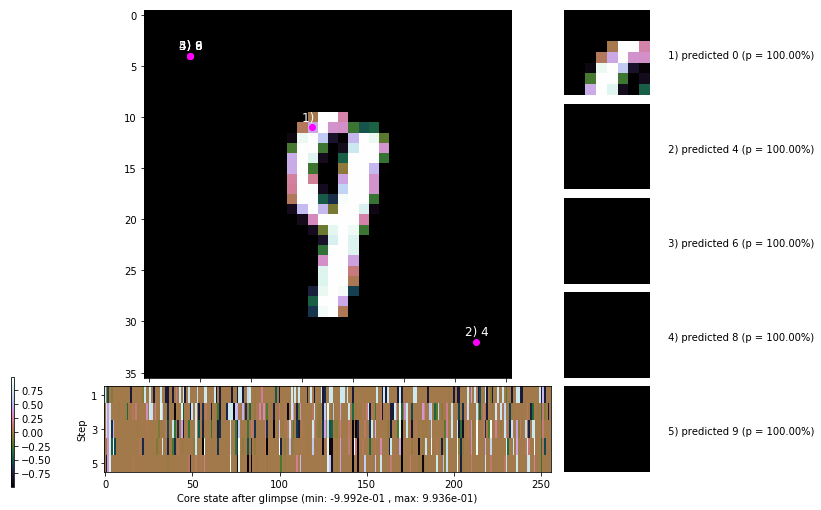


	Target class: 6 | Discounted rewards: [1.000, 1.000, 1.000, 1.000, 1.000, 1.000]


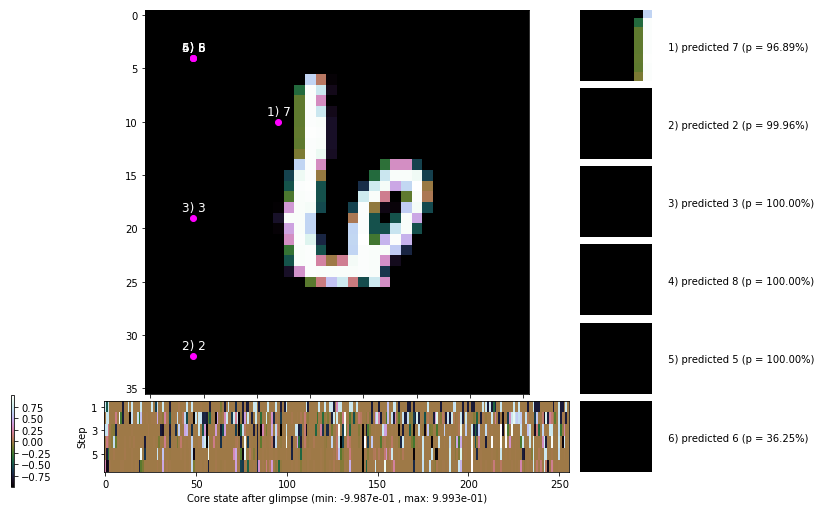

                                       ---===  MODEL PARAM DIAGNOSTICS  ===---


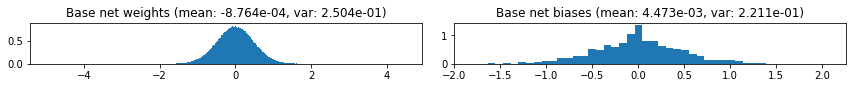

                                         Location network weights and biases


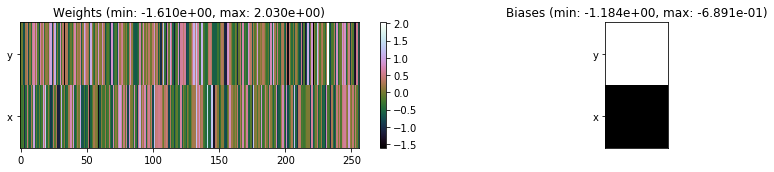

---------------------------------------------------------------------------------------------------------------------
Elapsed time: 6448.20 sec | TRAIN >> class loss: 0.8472 | steps:  3.665    | reward:  0.7800    | acc.: 77.995% 
                          | VAL   >> class loss: 0.7119 | steps:  3.653 :( | reward:  0.7826    | acc.: 78.260% 


Epoch  15/400) lr = 0.000349
 b  15000/ 60000 >> 108.7 ms/b | lr: 3.44e-04 | grad 2norm: 22.53 | grad inf norm:  5.726
         Weights || abs max:  4.999 (31328.727) | mean: -8.832e-04 ( 0.080) | var: 2.510e-01 (3153248.000)
          Biases || abs max:  2.078 (  155.242) | mean:  3.700e-03 ( 0.105) | var: 2.210e-01 ( 3053.710)
                    class loss: 0.780 | steps: 3.645 | reward:  0.780 | acc.: 78.01%
                 --------------------------------------------------------------------------------
 b  30000/ 60000 >> 113.0 ms/b | lr: 3.37e-04 | grad 2norm: 23.39 | grad inf norm:  5.836
         Weights || abs max:  5.050 (16808.590) | 

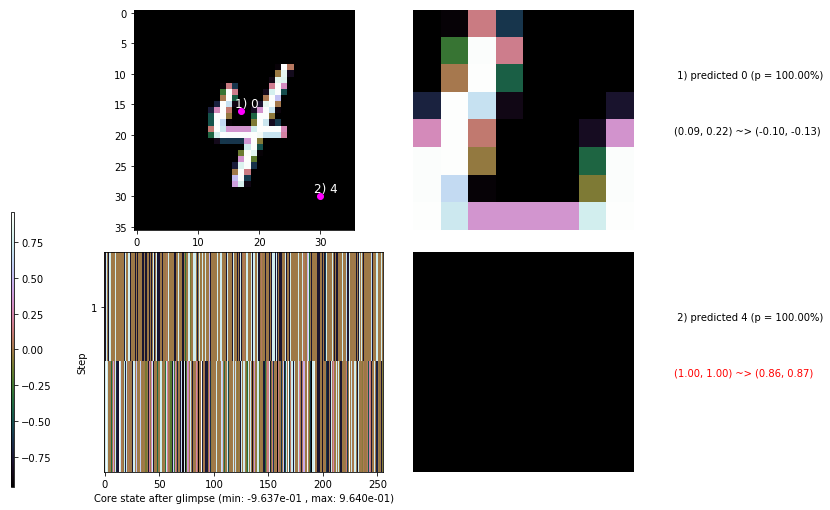

                 --------------------------------------------------------------------------------
 b  45000/ 60000 >> 101.2 ms/b | lr: 3.30e-04 | grad 2norm: 23.12 | grad inf norm:  5.726
         Weights || abs max:  5.061 (24401.834) | mean: -8.950e-04 ( 0.069) | var: 2.535e-01 (451875.812)
          Biases || abs max:  2.043 (  114.449) | mean:  3.387e-03 ( 0.080) | var: 2.215e-01 ( 2931.237)
                    class loss: 0.829 | steps: 3.653 | reward:  0.787 | acc.: 78.68%
                 --------------------------------------------------------------------------------
 b  60000/ 60000 >> 101.0 ms/b | lr: 3.25e-04 | grad 2norm: 23.63 | grad inf norm:  5.775
         Weights || abs max:  5.032 (24567.408) | mean: -8.900e-04 ( 0.070) | var: 2.546e-01 (367152.500)
          Biases || abs max:  2.016 (  119.824) | mean:  3.659e-03 ( 0.090) | var: 2.243e-01 (  760.678)
                    class loss: 0.847 | steps: 3.649 | reward:  0.789 | acc.: 78.94%

	Target class: 4 | Discounted r

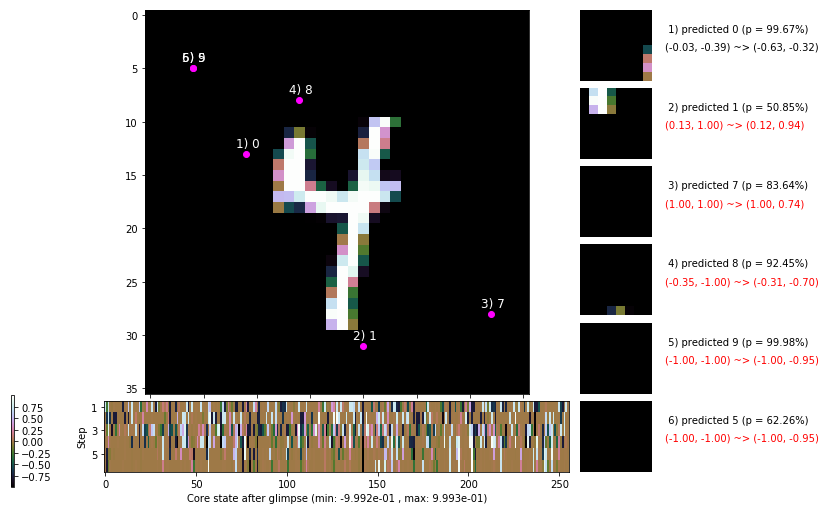

                 --------------------------------------------------------------------------------
                                             ---===  VALIDATION  ===---

	Target class: 3 | Discounted rewards: [1.000]


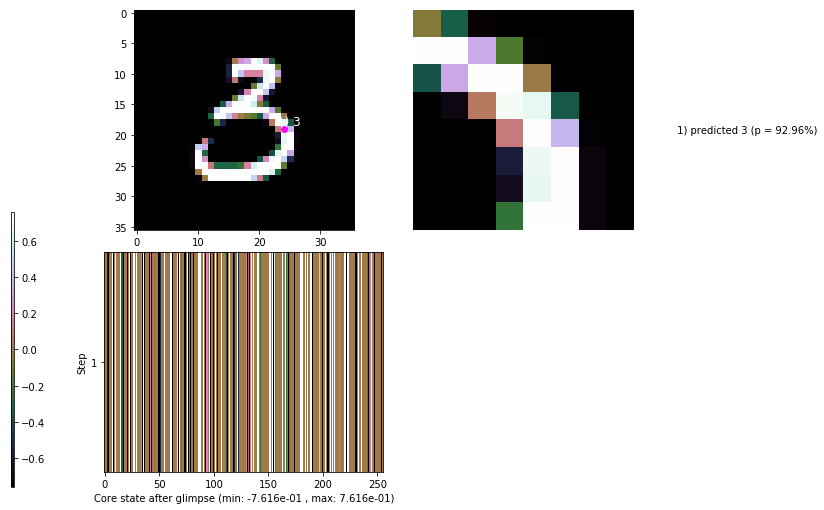


	Target class: 2 | Discounted rewards: [1.000, 1.000]


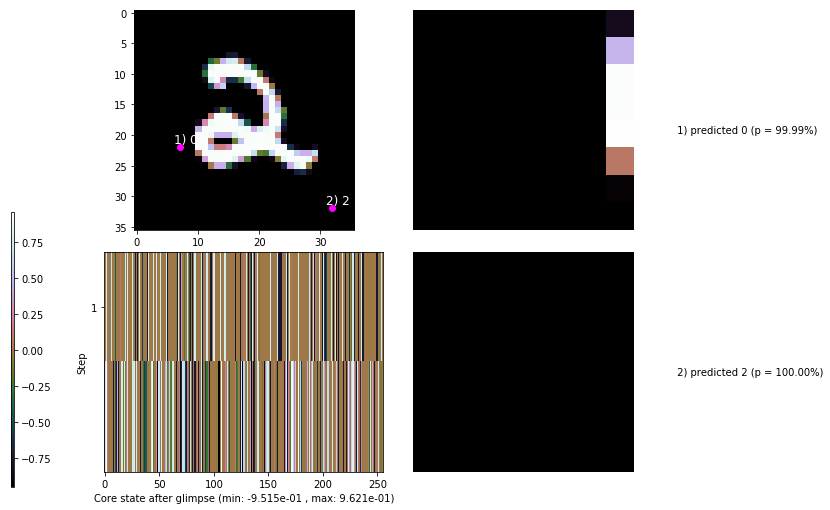

                                       ---===  MODEL PARAM DIAGNOSTICS  ===---


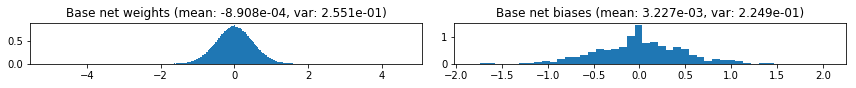

                                         Location network weights and biases


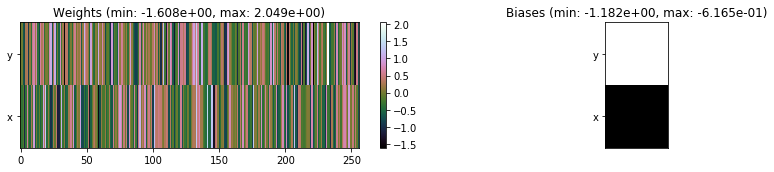

---------------------------------------------------------------------------------------------------------------------
Elapsed time: 6359.06 sec | TRAIN >> class loss: 0.8192 | steps:  3.652    | reward:  0.7854    | acc.: 78.542% 
                          | VAL   >> class loss: 0.8526 | steps:  3.616    | reward:  0.7924    | acc.: 79.240% 


Epoch  16/400) lr = 0.0003237
 b  15000/ 60000 >> 104.6 ms/b | lr: 3.19e-04 | grad 2norm: 23.22 | grad inf norm:  6.011
         Weights || abs max:  5.030 (30754.709) | mean: -9.351e-04 ( 0.080) | var: 2.557e-01 (2046426.125)
          Biases || abs max:  2.065 (  151.923) | mean:  3.148e-03 ( 0.110) | var: 2.256e-01 ( 1428.611)
                    class loss: 0.833 | steps: 3.661 | reward:  0.771 | acc.: 77.09%
                 --------------------------------------------------------------------------------
 b  30000/ 60000 >> 104.2 ms/b | lr: 3.13e-04 | grad 2norm: 23.72 | grad inf norm:  5.973
         Weights || abs max:  5.026 (24087.469) |

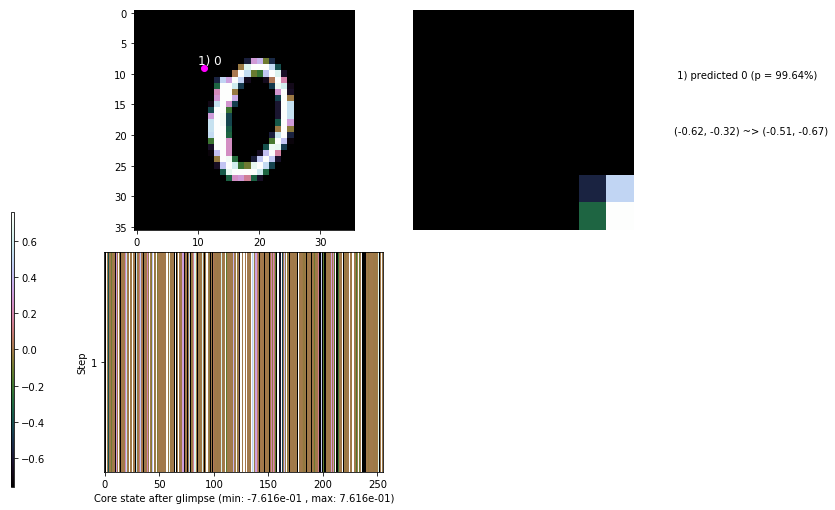

                 --------------------------------------------------------------------------------
 b  45000/ 60000 >> 102.6 ms/b | lr: 3.06e-04 | grad 2norm: 24.10 | grad inf norm:  6.007
         Weights || abs max:  5.037 (20942.729) | mean: -1.007e-03 ( 0.063) | var: 2.578e-01 (201353.828)
          Biases || abs max:  2.052 (  185.388) | mean:  3.770e-03 ( 0.116) | var: 2.297e-01 (32236.125)
                    class loss: 0.828 | steps: 3.657 | reward:  0.779 | acc.: 77.91%
                 --------------------------------------------------------------------------------
 b  60000/ 60000 >> 98.9 ms/b | lr: 3.02e-04 | grad 2norm: 23.69 | grad inf norm:  5.960
         Weights || abs max:  5.074 (25941.688) | mean: -1.079e-03 ( 0.073) | var: 2.587e-01 (584398.500)
          Biases || abs max:  2.040 (  171.374) | mean:  3.915e-03 ( 0.111) | var: 2.309e-01 ( 7890.969)
                    class loss: 0.838 | steps: 3.654 | reward:  0.778 | acc.: 77.81%

	Target class: 1 | Discounted re

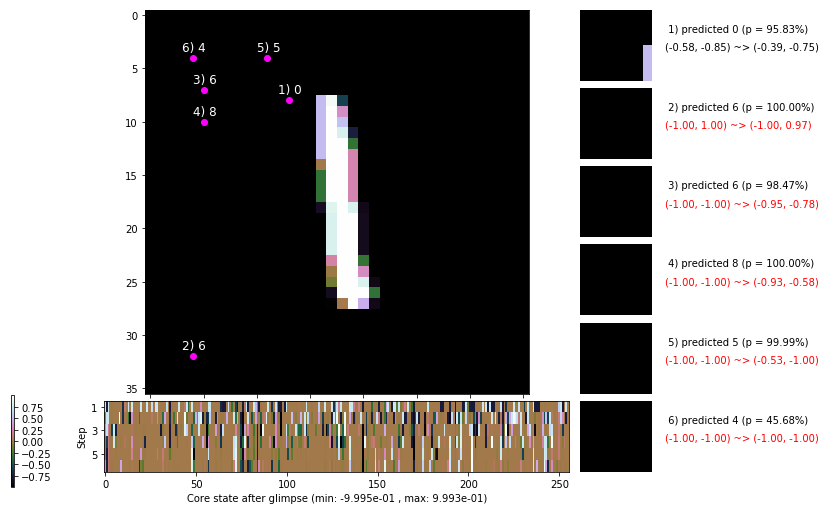

                 --------------------------------------------------------------------------------
                                             ---===  VALIDATION  ===---

	Target class: 2 | Discounted rewards: [1.000, 1.000, 1.000]


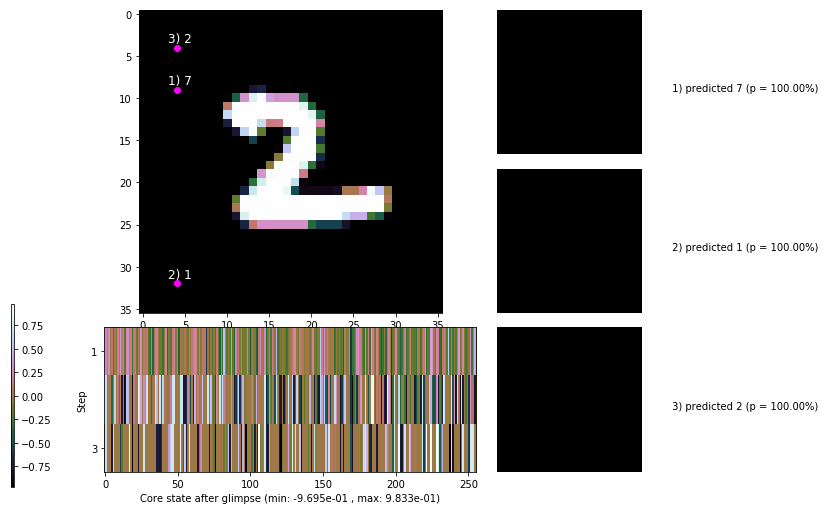


	Target class: 3 | Discounted rewards: [1.000]


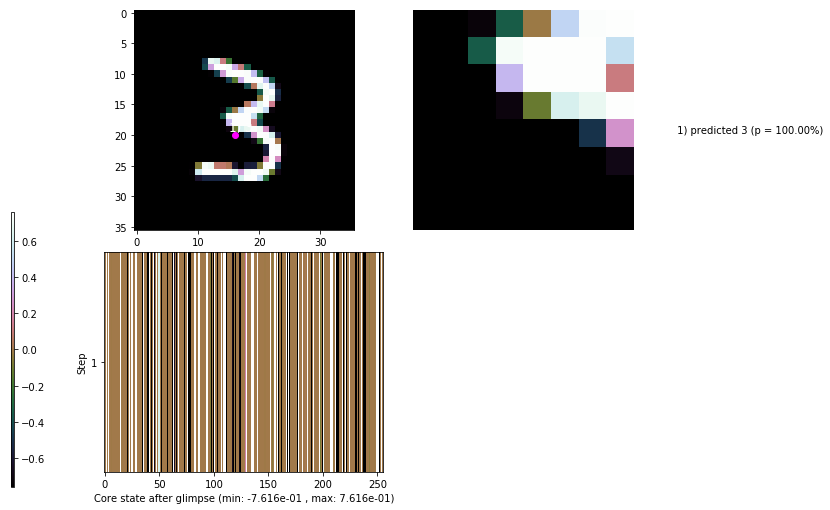

                                       ---===  MODEL PARAM DIAGNOSTICS  ===---


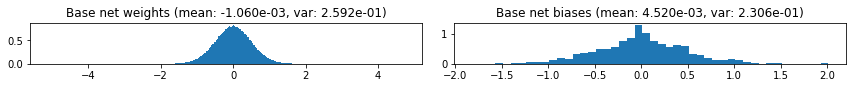

                                         Location network weights and biases


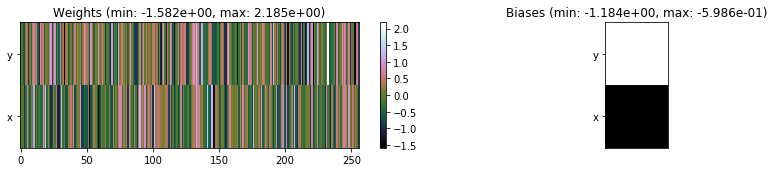

---------------------------------------------------------------------------------------------------------------------
Elapsed time: 6157.53 sec | TRAIN >> class loss: 0.8336 | steps:  3.651    | reward:  0.7766 :( | acc.: 77.662% :(
                          | VAL   >> class loss: 0.7970 | steps:  3.605    | reward:  0.7832 :( | acc.: 78.320% :(


Epoch  17/400) lr = 0.0003003
 b  15000/ 60000 >> 100.1 ms/b | lr: 2.96e-04 | grad 2norm: 24.33 | grad inf norm:  6.057
         Weights || abs max:  5.133 (      inf) | mean: -1.128e-03 (   inf) | var: 2.597e-01 (      nan)
          Biases || abs max:  1.987 (  206.055) | mean:  4.855e-03 ( 0.127) | var: 2.300e-01 (11982.101)
                    class loss: 0.833 | steps: 3.638 | reward:  0.774 | acc.: 77.41%
                 --------------------------------------------------------------------------------
 b  30000/ 60000 >> 98.4 ms/b | lr: 2.90e-04 | grad 2norm: 23.95 | grad inf norm:  5.938
         Weights || abs max:  5.169 (26637.580) 

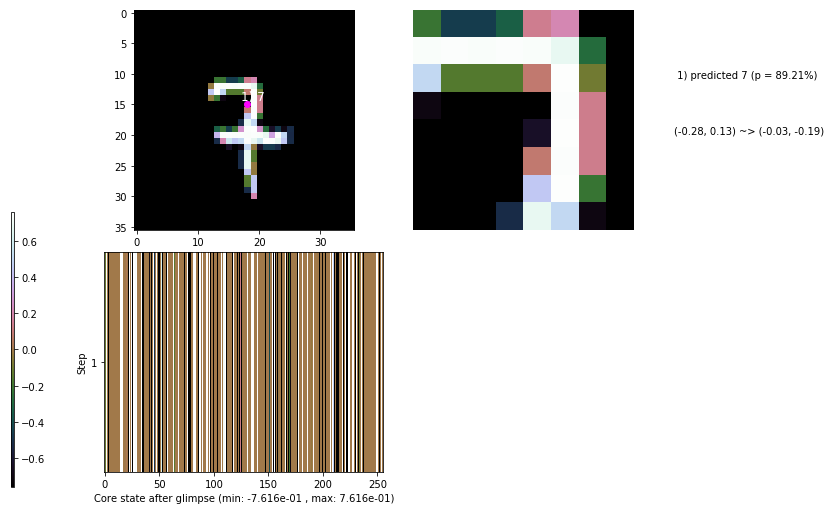

                 --------------------------------------------------------------------------------
 b  45000/ 60000 >> 99.7 ms/b | lr: 2.84e-04 | grad 2norm: 24.18 | grad inf norm:  5.936
         Weights || abs max:  5.179 (24849.539) | mean: -1.310e-03 ( 0.069) | var: 2.615e-01 (355522.094)
          Biases || abs max:  1.984 (  138.839) | mean:  2.767e-03 ( 0.094) | var: 2.304e-01 ( 2097.777)
                    class loss: 0.784 | steps: 3.607 | reward:  0.781 | acc.: 78.13%
                 --------------------------------------------------------------------------------
 b  60000/ 60000 >> 106.8 ms/b | lr: 2.80e-04 | grad 2norm: 23.83 | grad inf norm:  5.848
         Weights || abs max:  5.207 (15126.926) | mean: -1.298e-03 ( 0.050) | var: 2.624e-01 (27124.178)
          Biases || abs max:  1.980 (  724.125) | mean:  1.968e-03 ( 0.319) | var: 2.308e-01 (1964253.625)
                    class loss: 0.793 | steps: 3.615 | reward:  0.783 | acc.: 78.26%

	Target class: 8 | Discounted r

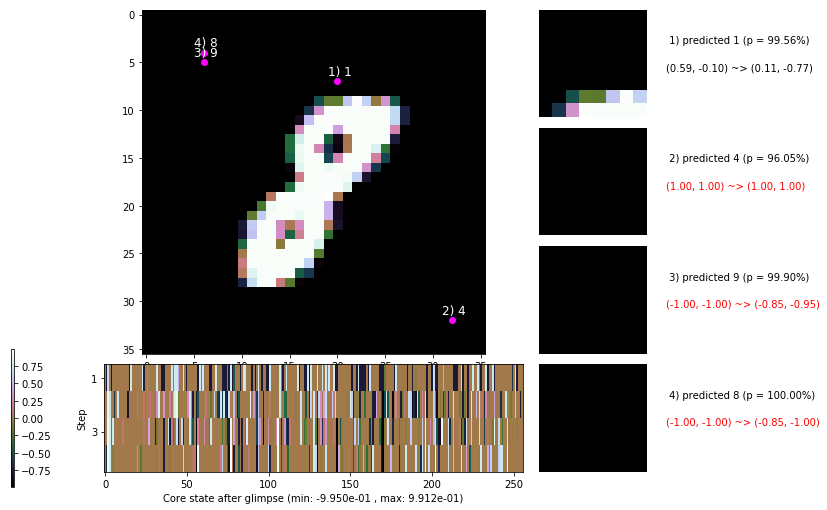

                 --------------------------------------------------------------------------------
                                             ---===  VALIDATION  ===---

	Target class: 6 | Discounted rewards: [0.000, 0.000, 0.000, 0.000, 0.000, 0.000]


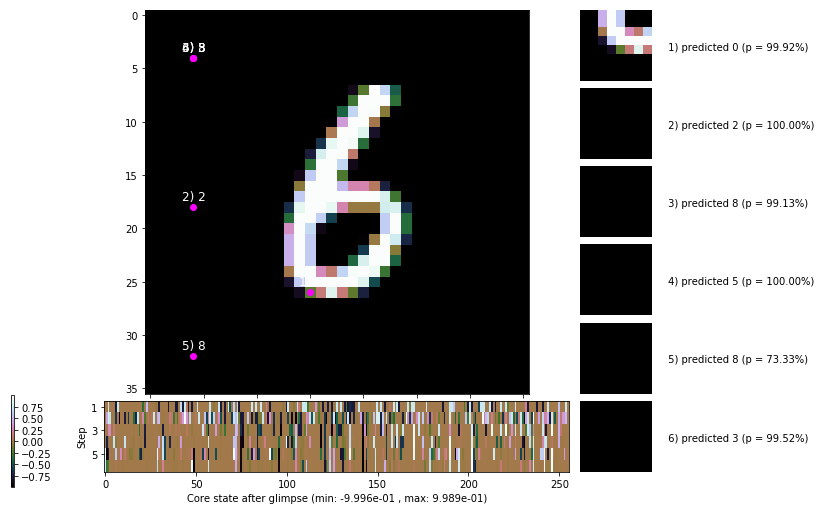


	Target class: 8 | Discounted rewards: [1.000, 1.000, 1.000, 1.000]


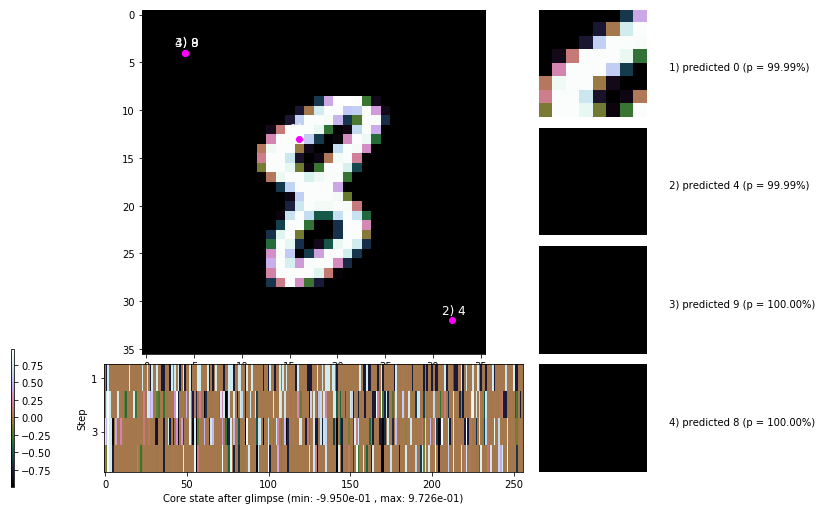

                                       ---===  MODEL PARAM DIAGNOSTICS  ===---


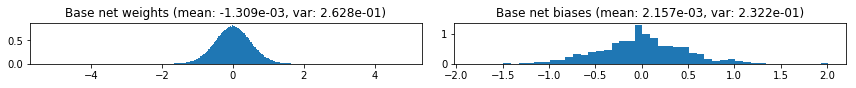

                                         Location network weights and biases


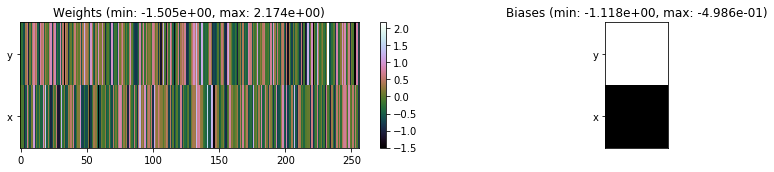

---------------------------------------------------------------------------------------------------------------------
Elapsed time: 6075.57 sec | TRAIN >> class loss: 0.8054 | steps:  3.626    | reward:  0.7788 :( | acc.: 77.878% :(
                          | VAL   >> class loss: 0.7775 | steps:  3.569    | reward:  0.7770 :( | acc.: 77.700% :(


Epoch  18/400) lr = 0.0002785


In [ ]:
model_info, train_info, val_info, test_info, epochs = train_eval_loop(
    model = model, epochs = num_epochs, image_size = image_size,
    train_data = train_data, val_data = val_data, test_data = test_data,
    padding = padding, optimizer = optimizer, lr_scheduler = lr_scheduler,
    class_criterion = class_criterion, error_penalty = error_penalty,
    loc_std = loc_std, random_start_loc = random_start_loc, gamma = gamma,
    grad_clip = grad_clip, steps_per_epoch = steps_per_epoch,
    max_ep_len = max_ep_len, log_freq = log_freq, viz_freq = viz_freq,
    early_stopping = early_stopping, eval_viz_freq = eval_viz_freq,
    end_train_ep_early = True
)

In [ ]:
print('Trained over %d epochs\n' % epochs)

for name, best_stats in zip(['train', 'val'], [train_info['bests'], val_info['bests']]):
    print('Best %s stats:' % name)
    for k, v in best_stats.items():
        print('    %s: %.3f (epoch %d)' % (k, v[k], v['epoch']))
    print('')

### Training curves

In [ ]:
epoch_range = range(1, epochs+1)
train_col = (1, 0, 0); train_err_col = (1, 0.1, 0.1)
val_col = (0, 0, 1); val_err_col = (0.1, 0.1, 1)

In [ ]:
wts_mean = np.array(model_info['weights']['mean'])
wts_var = np.array(model_info['weights']['var'])
bias_mean = np.array(model_info['biases']['mean'])
bias_var = np.array(model_info['biases']['var'])

fig, wts_ax = plt.subplots()
wts_ax.plot(epoch_range, wts_mean, color = train_col, linewidth = 2)
wts_ax.fill_between(epoch_range,
    wts_mean - wts_var, wts_mean + wts_var,
    alpha = 0.35, edgecolor = train_col, facecolor = train_err_col
)
wts_ax.set_xlabel('Epoch')
wts_ax.set_ylabel('Weights', color = train_col)

bias_ax = wts_ax.twinx()
bias_ax.plot(epoch_range, bias_mean, color = val_col, linewidth = 2)
bias_ax.fill_between(epoch_range,
    bias_mean - bias_var, bias_mean + bias_var,
    alpha = 0.35, edgecolor = val_col, facecolor = val_err_col
)
bias_ax.set_ylabel('Biases', color = val_col)

plt.title('Weight and bias values over training time')

In [ ]:
wts_absmax = np.array(model_info['weights']['abs max'])
bias_absmax = np.array(model_info['biases']['abs max'])

fig, wts_ax = plt.subplots()
wts_ax.plot(epoch_range, wts_absmax, color = train_col)
wts_ax.set_xlabel('Epoch')
wts_ax.set_ylabel('Weights', color = train_col)

bias_ax = wts_ax.twinx()
bias_ax.plot(epoch_range, bias_absmax, color = val_col)
bias_ax.set_ylabel('Biases', color = val_col)

plt.title('Max absolute weight and bias values over training time')

In [ ]:
things_to_plot = ['class_loss', 'steps', 'reward', 'accuracy']
for thing in things_to_plot:
    train_avg = np.array([info['averages'][thing] for info in train_info['stats']])
    train_err = np.array([np.var(info['histories'][thing]) for info in train_info['stats']])
    
    val_avg = np.array([info['averages'][thing] for info in val_info['stats']])
    val_err = np.array([np.var(info['histories'][thing]) for info in val_info['stats']])
    
    plt.plot(epoch_range, train_avg, color = train_col, linewidth = 2)
    plt.plot(epoch_range, val_avg, color = val_col, linewidth = 2)
    plt.fill_between(epoch_range,
        train_avg - train_err, train_avg + train_err, alpha = 0.35,
        edgecolor = train_col, facecolor = train_err_col
    )
    plt.fill_between(epoch_range,
        val_avg - val_err, val_avg + val_err, alpha = 0.35,
        edgecolor = val_col, facecolor = val_err_col
    )
    if thing == 'steps':
        plt.ylim([0, 6])
    plt.legend(['Train', 'Validation'], loc = 'upper right' if thing in ['class_loss', 'steps'] else 'lower right')
    plt.xlabel('Epoch'); plt.ylabel(thing)
    plt.title('%s over time' % thing)
    plt.show()
    print('')

In [ ]:
# Gradient stats
grad_2norm = np.array([info['averages']['grad_2norm'] for info in train_info['stats']])
grad_inf_norm = np.array([info['averages']['grad_inf_norm'] for info in train_info['stats']])
grad_2norm_err = np.array([np.var(info['histories']['grad_2norm']) for info in train_info['stats']])
grad_inf_norm_err = np.array([np.var(info['histories']['grad_inf_norm']) for info in train_info['stats']])

fig, pnorm_ax = plt.subplots()
pnorm_ax.plot(epoch_range, grad_2norm, color = train_col, linewidth = 2)
pnorm_ax.fill_between(epoch_range,
    grad_2norm - grad_2norm_err, grad_2norm + grad_2norm_err,
    alpha = 0.35, edgecolor = train_col, facecolor = train_err_col
)
pnorm_ax.set_xlabel('Epoch');
pnorm_ax.set_ylabel('2-norm', color = train_col)

infnorm_ax = pnorm_ax.twinx()
infnorm_ax.plot(epoch_range, grad_inf_norm, color = val_col, linewidth = 2)
infnorm_ax.fill_between(epoch_range,
    grad_inf_norm - grad_inf_norm_err, grad_inf_norm + grad_inf_norm_err,
    alpha = 0.35, edgecolor = val_col, facecolor = val_err_col
)
infnorm_ax.set_ylabel('infinite norm', color = val_col)

plt.title('Gradient norms over training time')